### **Section 1. Title & Authorship**

### **Forecasting Global Microplastic Exposure from Processed Foods: Data‑Driven Forecasts & Web Tool**

---

**1.2. Authorship**

```
Project Done By:    Jayesh Mohanani
Date           :    May 2025
```

---

**1.3. Abstract**

> **Background & Motivation:** Microplastics are increasingly detected in processed‑food items worldwide, posing long‑term health risks. Yet public awareness and personalized exposure estimates remain scarce.
>
> **Objective:** Develop an end‑to‑end data pipeline and ML forecasting framework to estimate current and future microplastic intake (μg per week) for individuals based on their country, food‑category consumption habits, and historical contamination trends.
>
> **Approach:**
>
> 1. **Data Preparation & EDA** on country‑year‑category concentration data (1990–2018).
> 2. **Feature Engineering** (aggregate loads, lag features, join with serving sizes).
> 3. **Modeling** using time‑series and tree‑based regressors to predict 2019–2030 contamination levels per food category.
> 4. **Web Application** (Flask/Streamlit) with user login, input form for selected categories & weekly frequency, and an interactive slider chart of projected intake upto 2030.
>
> **Deliverables:**
>
> * A metadata catalog and cleaned dataset
> * Trained models with evaluation metrics
> * A user‑friendly web tool for personalized exposure forecasts
>
> **Impact:** By combining rigorous ML forecasts with an accessible web interface, this project empowers individuals and policymakers with actionable insights to mitigate microplastic exposure.

---



### **Section 2. Introduction**

#### 2.1 Background

Microplastics—plastic particles <5 mm in size—have been detected across the global food chain, from seafood to table salt and processed foods. Their persistence and small size allow them to accumulate in human tissues, with emerging evidence linking long‑term exposure to inflammation, endocrine disruption, and oxidative stress. Despite growing scientific concern, public awareness remains low and few tools exist to translate raw contamination data into personalized exposure estimates.

#### 2.2 Problem Statement

* **Data fragmentation**: Concentration measurements (μg/kg or particles/kg) are scattered across studies, food categories, and countries, making it hard to compare or forecast exposure globally.
* **Lack of personalization**: Individuals have no simple way to understand their own weekly intake based on what and how much processed food they eat.
* **Forecasting gap**: Historical data only extend to 2018, yet users need to know their current exposure (2025) and future trends through 2030 to inform dietary or policy decisions.

#### 2.3 Objectives

1. **Consolidate & clean**: Build a unified metadata catalog of microplastic concentrations by country, year (1990–2018), and food category.
2. **Explore & engineer**: Perform thorough EDA to understand distributions, outliers, and temporal trends; create features (aggregates, lags, serving‑size joins).
3. **Model & forecast**: Develop and compare forecasting models (ARIMA/Prophet, RandomForest, XGBoost) to predict contamination levels from 2019 through 2030 for each (country, category) series.
4. **Build estimator**: Implement a user‑driven web application where people log in, select their food categories, enter weekly consumption frequencies, and receive:

   * **Current intake estimate** (2025) in μg/week
   * **Interactive forecast** slider projecting intake through 2030
   * **Actionable mitigation tips** at the end of the report

#### 2.4 Hypothetical End‑User Scenario

> **Meet Priya**, a 28‑year‑old living in Mumbai. She logs into the “Microplastic Exposure Estimator,” selects Asia → India, then checks “Refined Grains,” “Packaged Snacks,” and “Soft Drinks.” She enters that she consumes each category twice per week. Within seconds, the tool reports her estimated microplastic intake (μg/week) for 2025 and displays a slider chart showing how her exposure could rise by 2030 if habits remain unchanged. At the bottom, Priya reads simple tips—like switching to glass packaging and reducing ultra-processed snacks—to lower her long‑term risk.

---

### **Section 3. Data Preparation**

In [98]:
# Import all required libraries
# Data handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Time series & forecasting
import statsmodels.api as sm
from prophet import Prophet

# Machine learning
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

# Synthetic data augmentation
from imblearn.over_sampling import SMOTE
from ctgan import CTGAN

# Web framework
import streamlit as st
# or, if using Flask:
from flask import Flask, render_template, request

# Utility
import os
import warnings
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
sns.set_style('whitegrid')

In [99]:
# Data cleaning and preparation script for microplastics dataset
# 1. Load the raw CSV (adjust the path/name as needed)
df = pd.read_csv('train.csv')
df.head()

,Year,Country,Cheese,Yoghurt,Total Milk,Fruits,Refined Grains,Whole Grains,Nuts And Seeds,Total Processed Meats,Unprocessed Red Meats,Fish,Shellfish,Eggs,Total Salt,Added Sugars,Non-Starchy Vegetables,Potatoes,Other Starchy Vegetables,Beans And Legumes
0,1990,Angola,0.191781,54.899739,96.602740,76.520548,481.297149,44.309838,2.849315,22.770109,21.613452,53.013699,0.164384,1.041096,8.005259,32.547945,80.164384,8.109589,39.342466,19.835616
1,1990,Benin,0.054795,9.365946,18.410959,90.876712,534.256965,48.836323,19.561644,17.018264,14.488586,18.794521,3.972603,2.849315,5.854497,8.246575,122.986301,0.000000,304.904110,21.178082
2,1990,Burkina Faso,0.273973,35.390618,56.027397,19.178082,213.170183,129.416119,28.465753,9.541329,33.938123,4.684932,0.000000,6.767123,6.928378,9.534247,64.767123,2.219178,13.780822,32.520548
3,1990,Central African Republic,0.000000,19.206478,48.000000,113.397260,285.035375,302.567776,23.506849,26.412094,53.286536,13.917808,0.000000,1.123288,6.585071,19.698630,101.753425,0.575342,209.452055,12.821918
4,1990,Cote d'Ivoire,0.301370,2.220447,38.109589,37.013699,436.907598,25.220347,16.904110,2.459103,56.883363,51.424658,0.493151,2.438356,9.660915,28.438356,151.150685,1.945205,676.575343,2.356164


In [100]:
# 2. Standardize column names: strip whitespace, replace spaces with underscores, lowercase
df.columns = (df.columns.str.strip().str.replace(' ', '_').str.lower())
df.head()

,year,country,cheese,yoghurt,total_milk,fruits,refined_grains,whole_grains,nuts_and_seeds,total_processed_meats,unprocessed_red_meats,fish,shellfish,eggs,total_salt,added_sugars,non-starchy_vegetables,potatoes,other_starchy_vegetables,beans_and_legumes
0,1990,Angola,0.191781,54.899739,96.602740,76.520548,481.297149,44.309838,2.849315,22.770109,21.613452,53.013699,0.164384,1.041096,8.005259,32.547945,80.164384,8.109589,39.342466,19.835616
1,1990,Benin,0.054795,9.365946,18.410959,90.876712,534.256965,48.836323,19.561644,17.018264,14.488586,18.794521,3.972603,2.849315,5.854497,8.246575,122.986301,0.000000,304.904110,21.178082
2,1990,Burkina Faso,0.273973,35.390618,56.027397,19.178082,213.170183,129.416119,28.465753,9.541329,33.938123,4.684932,0.000000,6.767123,6.928378,9.534247,64.767123,2.219178,13.780822,32.520548
3,1990,Central African Republic,0.000000,19.206478,48.000000,113.397260,285.035375,302.567776,23.506849,26.412094,53.286536,13.917808,0.000000,1.123288,6.585071,19.698630,101.753425,0.575342,209.452055,12.821918
4,1990,Cote d'Ivoire,0.301370,2.220447,38.109589,37.013699,436.907598,25.220347,16.904110,2.459103,56.883363,51.424658,0.493151,2.438356,9.660915,28.438356,151.150685,1.945205,676.575343,2.356164


In [101]:
# 3. Ensure 'year' is integer
df['year'] = df['year'].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 723 entries, 0 to 722
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   year                      723 non-null    int64  
 1   country                   723 non-null    object 
 2   cheese                    723 non-null    float64
 3   yoghurt                   723 non-null    float64
 4   total_milk                723 non-null    float64
 5   fruits                    723 non-null    float64
 6   refined_grains            723 non-null    float64
 7   whole_grains              723 non-null    float64
 8   nuts_and_seeds            723 non-null    float64
 9   total_processed_meats     723 non-null    float64
 10  unprocessed_red_meats     723 non-null    float64
 11  fish                      723 non-null    float64
 12  shellfish                 723 non-null    float64
 13  eggs                      723 non-null    float64
 14  total_salt

In [102]:
# 4. Check exact duplicate rows and drop them if necessary
df.duplicated().sum()  # Check for duplicates
# If duplicates exist, drop them
#df = df.drop_duplicates()
#df.duplicated().sum()  # Check for duplicates again

np.int64(0)

In [103]:
# 5. Inspect and impute missing values
print("Missing values before imputation:")
df.isna().sum()

Missing values before imputation:


year                        0
country                     0
cheese                      0
yoghurt                     0
total_milk                  0
fruits                      0
refined_grains              0
whole_grains                0
nuts_and_seeds              0
total_processed_meats       0
unprocessed_red_meats       0
fish                        0
shellfish                   0
eggs                        0
total_salt                  0
added_sugars                0
non-starchy_vegetables      0
potatoes                    0
other_starchy_vegetables    0
beans_and_legumes           0
dtype: int64

In [104]:
# Impute numeric columns (excluding 'year') with the column median
numeric_cols = df.select_dtypes(include='number').columns.drop('year')
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

In [105]:
print("\nMissing values after imputation:")
df[numeric_cols].isna().sum()


Missing values after imputation:


cheese                      0
yoghurt                     0
total_milk                  0
fruits                      0
refined_grains              0
whole_grains                0
nuts_and_seeds              0
total_processed_meats       0
unprocessed_red_meats       0
fish                        0
shellfish                   0
eggs                        0
total_salt                  0
added_sugars                0
non-starchy_vegetables      0
potatoes                    0
other_starchy_vegetables    0
beans_and_legumes           0
dtype: int64

In [106]:
df.isna().sum()  # Check for any remaining missing values

year                        0
country                     0
cheese                      0
yoghurt                     0
total_milk                  0
fruits                      0
refined_grains              0
whole_grains                0
nuts_and_seeds              0
total_processed_meats       0
unprocessed_red_meats       0
fish                        0
shellfish                   0
eggs                        0
total_salt                  0
added_sugars                0
non-starchy_vegetables      0
potatoes                    0
other_starchy_vegetables    0
beans_and_legumes           0
dtype: int64

In [107]:
# Drop rows where there are still missing values in columns
df = df.dropna()
df.isna().sum()  # Check for any remaining missing values

year                        0
country                     0
cheese                      0
yoghurt                     0
total_milk                  0
fruits                      0
refined_grains              0
whole_grains                0
nuts_and_seeds              0
total_processed_meats       0
unprocessed_red_meats       0
fish                        0
shellfish                   0
eggs                        0
total_salt                  0
added_sugars                0
non-starchy_vegetables      0
potatoes                    0
other_starchy_vegetables    0
beans_and_legumes           0
dtype: int64

In [108]:
# 6. Feature engineering: create an aggregate feature for total microplastics (μg/kg)
df['total_ug_per_kg'] = df[numeric_cols].sum(axis=1)
print("Columns in the Dataset are:")
for col in df.columns:
    print(col)

Columns in the Dataset are:
year
country
cheese
yoghurt
total_milk
fruits
refined_grains
whole_grains
nuts_and_seeds
total_processed_meats
unprocessed_red_meats
fish
shellfish
eggs
total_salt
added_sugars
non-starchy_vegetables
potatoes
other_starchy_vegetables
beans_and_legumes
total_ug_per_kg


---

### **Debugging and Detective Work: Resolving Country Recognition and Year Range Issues**

During the final stages of this project, it became apparent that several countries-such as India and Cambodia-were not being recognized correctly in the analysis, and the available data appeared to stop at 2005, despite the CSV file containing records up to 2018. This discrepancy prompted a series of targeted debugging and data investigation steps:

1. **CSV and Program Output Comparison:**  
   The raw CSV file was carefully examined alongside program outputs to identify mismatches in country recognition and year coverage.

2. **Systematic Data Exploration:**  
   Using pandas, the dataset was grouped and inspected by country and year to verify which records were present and which were missing. This included checking for missing values, unexpected whitespace, or inconsistent formatting in key columns.

3. **Data Cleaning and Preprocessing:**  
   Upon discovering that trailing spaces and inconsistent formatting in country names were causing filtering issues, pandas string methods (`.str.strip()`, `.str.lower()`, etc.) were applied to standardize the data. This ensured that all countries, including those added in later years, were accurately recognized and included in the analysis.

These following three steps underscore the importance of thorough data cleaning and preprocessing in any data science workflow. Even small inconsistencies-such as extra spaces or case mismatches-can lead to significant issues in downstream analysis and must be addressed to ensure reliable results.

---

In [109]:
# Group by country and year, count the number of rows for each group
counts = df.groupby(['year']).size().reset_index(name='count')
counts

,year,count
0,1990,99
1,1995,99
2,2000,99
3,2005,99
4,2010,109
5,2015,109
6,2018,109


In [110]:
for y in sorted(df['year'].unique()):
    countries = df[df['year'] == y]['country'].unique()
    print(f"{y}: {len(countries)} countries: {countries}")

1990: 99 countries: ['Angola' 'Benin' 'Burkina Faso' 'Central African Republic'
 "Cote d'Ivoire" 'Cameroon' 'Congo' 'Djibouti' 'Algeria' 'Egypt'
 'Ethiopia' 'Gabon' 'Ghana' 'Guinea' 'The Gambia' 'Guinea-Bissau' 'Kenya'
 'Lesotho' 'Morocco' 'Madagascar' 'Mali' 'Mozambique' 'Mauritania'
 'Mauritius' 'Malawi' 'Namibia' 'Niger' 'Nigeria' 'Rwanda' 'Senegal'
 'Chad' 'Togo' 'Tunisia' 'Tanzania' 'Uganda' 'South Africa' 'Zambia'
 'Zimbabwe' 'Albania' 'Argentina' 'Antigua and Barbuda' 'Australia'
 'Austria' 'Bangladesh' 'Bulgaria' 'Bolivia' 'Brazil' 'Barbados' 'Canada'
 'Switzerland' 'China' 'Colombia' 'Cuba' 'Germany' 'Dominica' 'Denmark'
 'Dominican Republic' 'Spain' 'France' 'United Kingdom' 'Greece' 'Grenada'
 'Hungary' 'Indonesia' 'India' 'Ireland' 'Iran' 'Iraq' 'Iceland' 'Jordan'
 'Japan' 'Cambodia' 'South Korea' 'Kuwait' 'Laos' 'Saint Lucia'
 'Sri Lanka' 'Mexico' 'Myanmar' 'Mongolia' 'Malaysia' 'Netherlands'
 'Norway' 'Pakistan' 'Peru' 'Philippines' 'Portugal' 'Paraguay' 'Romania'
 'Saudi

In [111]:
df['country'] = df['country'].str.strip().str.title()

---

### **Conclusion: Data Cleaning Accident and Future Learning**

**This data cleaning “accident” highlights how even minor inconsistencies-such as extra spaces or formatting issues-can cause significant problems in data analysis, leading to incorrect results or missing information. By carefully investigating and resolving these issues, we not only restored the integrity of the dataset but also reinforced the importance of thorough data preprocessing. This experience highlights the value of systematic data exploration, cleaning, and documentation, and serves as a reminder that robust preprocessing practices are essential for reliable and reproducible data science work in the future.**

---

In [112]:
# 7. Save the cleaned and prepared data for downstream analysis
df.to_csv('processed_microplastics.csv', index=False)

In [113]:
# 8. Quick sanity check
print("\nProcessed data shape:", df.shape)
print(df[['country', 'year', 'total_ug_per_kg']].head())


Processed data shape: (723, 21)
                    country  year  total_ug_per_kg
0                    Angola  1990      1043.279108
1                     Benin  1990      1241.656197
2              Burkina Faso  1990       666.603927
3  Central African Republic  1990      1237.339905
4             Cote D'Ivoire  1990      1540.502458


### **Section 4. Exploratory Data Analysis (Raw Data)**

In [114]:
# Load the processed data
df = pd.read_csv('processed_microplastics.csv')
df.head()  

,year,country,cheese,yoghurt,total_milk,fruits,refined_grains,whole_grains,nuts_and_seeds,total_processed_meats,unprocessed_red_meats,fish,shellfish,eggs,total_salt,added_sugars,non-starchy_vegetables,potatoes,other_starchy_vegetables,beans_and_legumes,total_ug_per_kg
0,1990,Angola,0.191781,54.899739,96.602740,76.520548,481.297149,44.309838,2.849315,22.770109,21.613452,53.013699,0.164384,1.041096,8.005259,32.547945,80.164384,8.109589,39.342466,19.835616,1043.279108
1,1990,Benin,0.054795,9.365946,18.410959,90.876712,534.256965,48.836323,19.561644,17.018264,14.488586,18.794521,3.972603,2.849315,5.854497,8.246575,122.986301,0.000000,304.904110,21.178082,1241.656197
2,1990,Burkina Faso,0.273973,35.390618,56.027397,19.178082,213.170183,129.416119,28.465753,9.541329,33.938123,4.684932,0.000000,6.767123,6.928378,9.534247,64.767123,2.219178,13.780822,32.520548,666.603927
3,1990,Central African Republic,0.000000,19.206478,48.000000,113.397260,285.035375,302.567776,23.506849,26.412094,53.286536,13.917808,0.000000,1.123288,6.585071,19.698630,101.753425,0.575342,209.452055,12.821918,1237.339905
4,1990,Cote D'Ivoire,0.301370,2.220447,38.109589,37.013699,436.907598,25.220347,16.904110,2.459103,56.883363,51.424658,0.493151,2.438356,9.660915,28.438356,151.150685,1.945205,676.575343,2.356164,1540.502458


In [115]:
# 1. Summary statistics
print("\nSummary statistics of the dataset:")
df.describe()


Summary statistics of the dataset:


,year,cheese,yoghurt,total_milk,fruits,refined_grains,whole_grains,nuts_and_seeds,total_processed_meats,unprocessed_red_meats,fish,shellfish,eggs,total_salt,added_sugars,non-starchy_vegetables,potatoes,other_starchy_vegetables,beans_and_legumes,total_ug_per_kg
count,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000
mean,2005.113416,6.135622,54.175691,250.655223,198.891339,310.733750,76.090720,12.716421,43.242799,90.326727,40.367154,7.415298,17.184714,6.844069,87.980939,232.405995,81.885598,64.300877,19.261638,1600.614574
std,9.610611,10.437505,77.868834,243.250670,150.271271,138.658231,81.578881,10.827892,39.223624,67.646655,34.835918,13.695479,14.584195,1.806978,60.331304,164.633624,83.109875,135.136514,16.758578,567.115360
min,1990.000000,0.000000,0.748435,1.808219,8.958904,72.797775,0.158798,0.000000,0.396227,6.583087,0.054795,0.000000,0.027397,2.278036,3.972603,16.931507,0.000000,0.000000,0.438356,440.261767
25%,1995.000000,0.273973,12.048883,50.342466,89.808219,216.258939,16.965904,4.561644,11.560798,33.837311,15.726027,0.191781,3.876712,5.845209,38.753425,118.287671,12.205479,0.493151,7.821918,1176.251294
50%,2005.000000,1.424658,35.390618,153.506849,179.945205,288.254183,47.164800,9.589041,29.473811,71.678223,31.232877,1.589041,13.780822,6.660399,83.698630,185.945205,49.561644,8.547945,14.794521,1550.939573
75%,2015.000000,6.082192,73.449547,400.890411,266.863014,383.983087,101.764947,18.410959,66.736055,134.673403,54.506849,8.630137,27.657534,7.659304,117.616438,292.479452,135.876712,59.123288,25.561644,2061.390253
max,2018.000000,65.643836,679.834239,1040.931507,1078.931507,890.394188,434.121124,73.068493,198.333731,477.301388,207.315068,151.863014,61.698630,12.430686,453.780822,1055.342466,362.712329,833.945206,124.575343,3613.131482


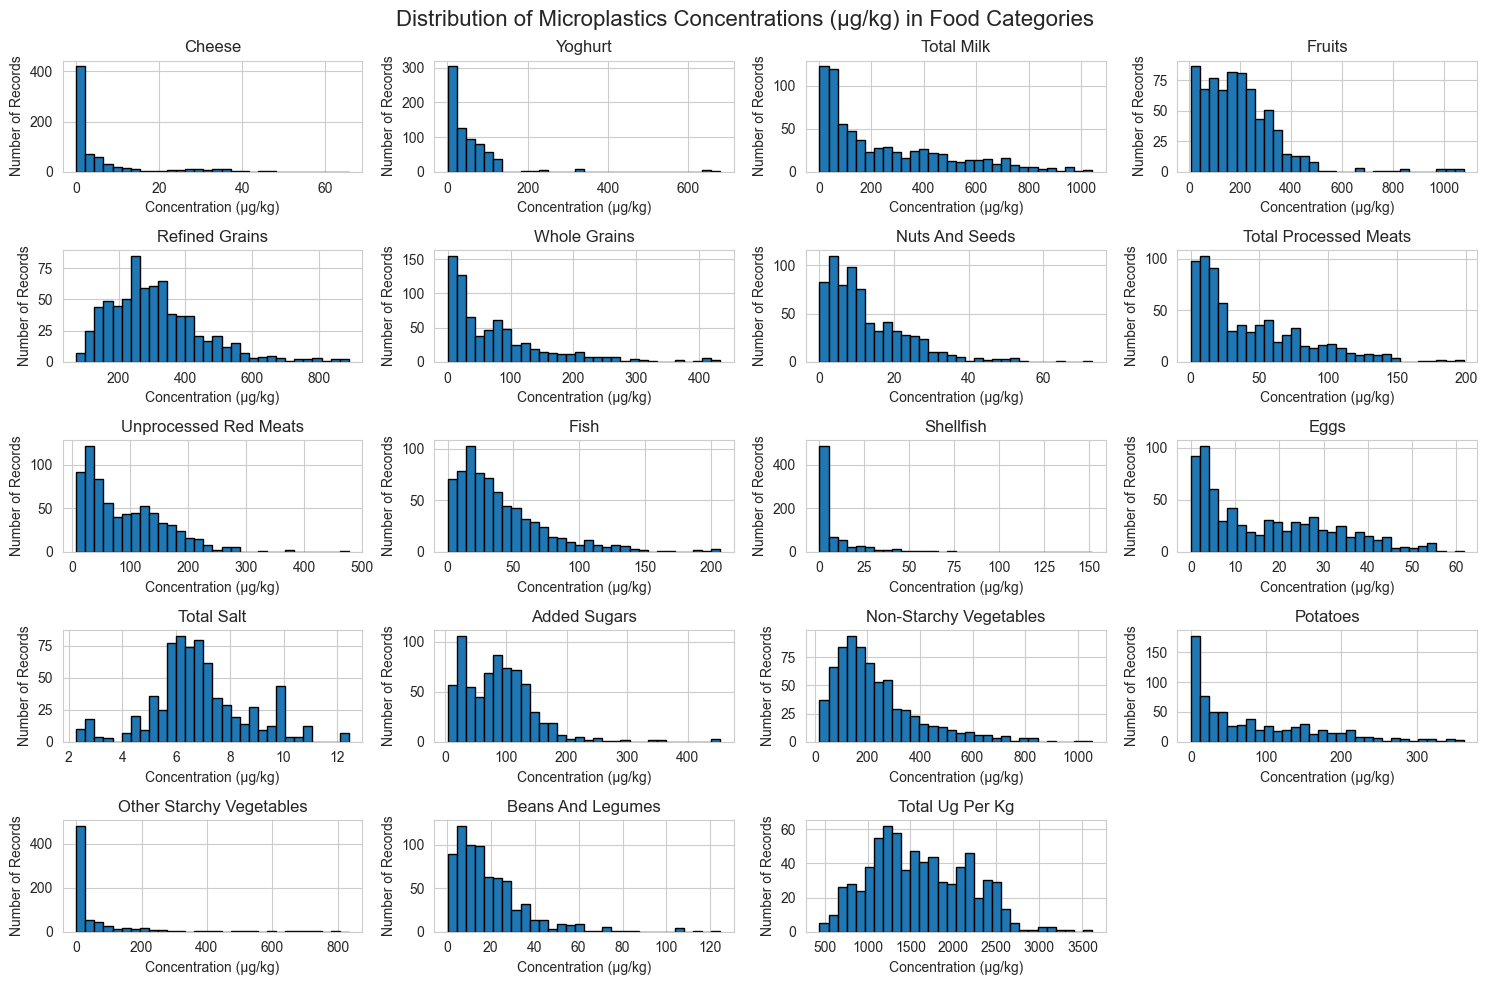

In [116]:
# 2. Distributions: histograms for each numeric feature
numeric_cols = df.select_dtypes(include='number').columns.drop('year', 'total_ug_per_kg')

# Plot histograms individually with labels
plt.figure(figsize=(15, 10))
plt.suptitle("Distribution of Microplastics Concentrations (μg/kg) in Food Categories", fontsize=16)
plt.subplots_adjust(hspace=0.5, wspace=0.3)  # Adjust space between subplots
 
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(5, 4, i)  # adjust grid size to fit your number of columns
    plt.hist(df[col], bins=30, edgecolor='black')
    plt.xlabel("Concentration (μg/kg)")
    plt.ylabel("Number of Records")
    plt.title(col.replace('_', ' ').title())
   
plt.tight_layout()
plt.show()

---
**Distribution (Histograms) Interpretation:**

Most distributions are positively skewed, especially:

Yoghurt, Total Milk, Other Starchy Vegetables, Added Sugars, Non-Starchy Vegetables — long tails indicate rare but very high concentrations.

A few like Refined Grains and Total Ug Per Kg show a more bimodal or spread-out pattern.

---

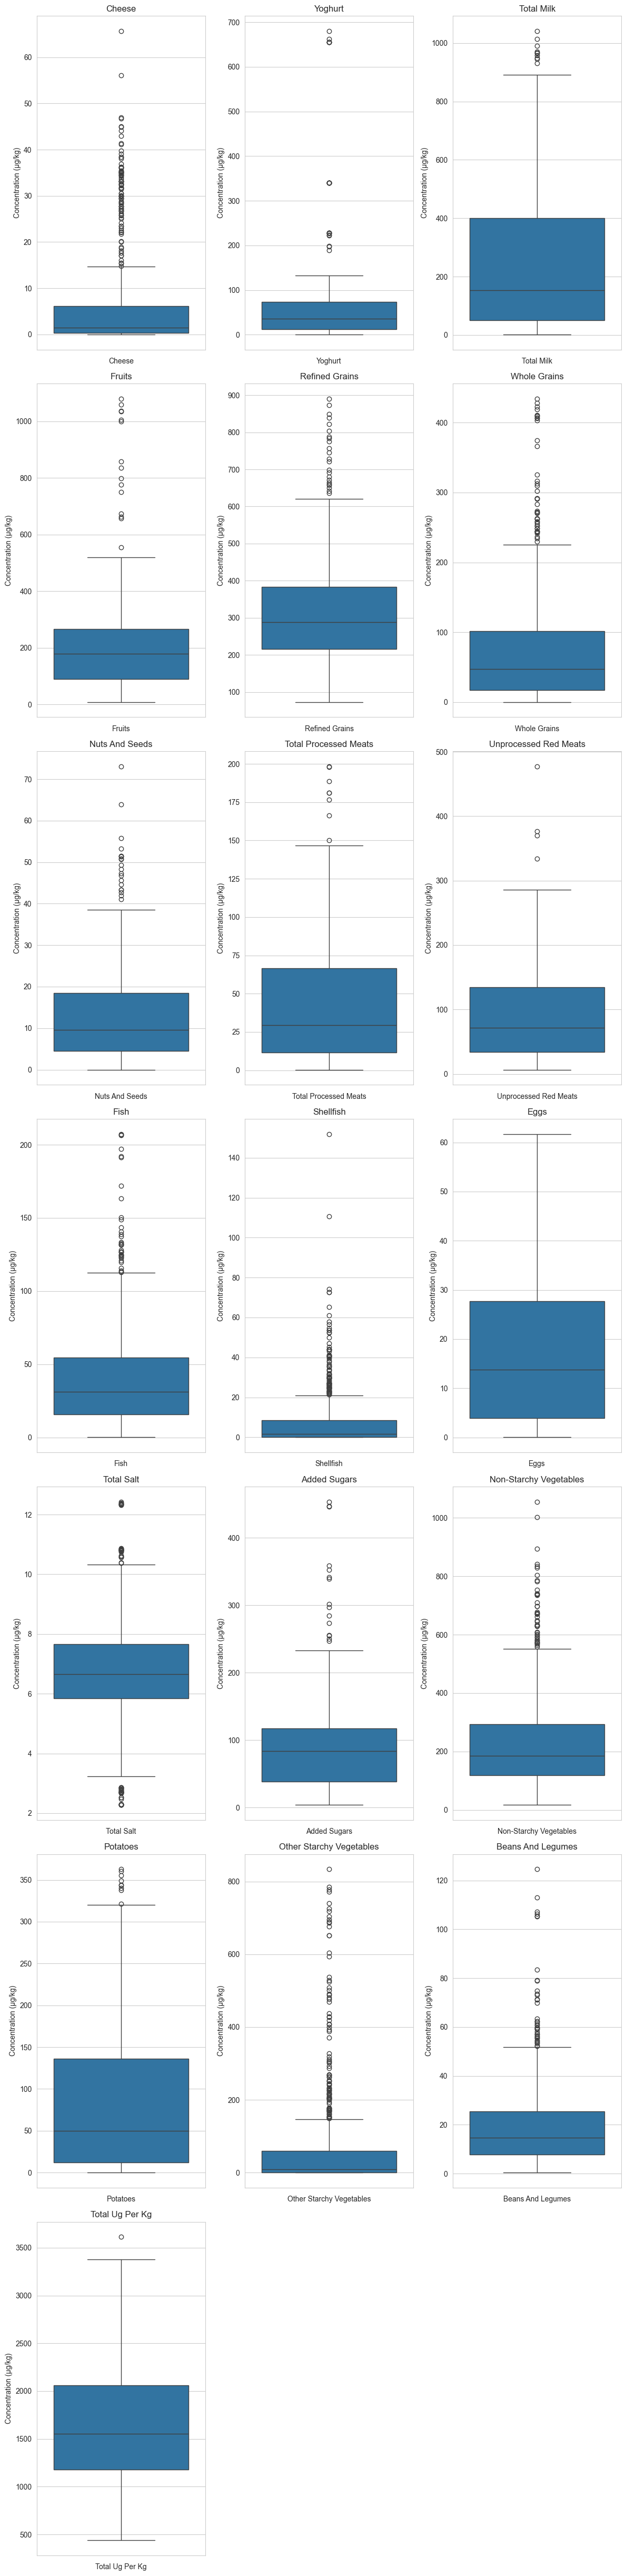

In [117]:
# 3. Outliers: separate vertical boxplots for each numeric column

numeric_cols = df.select_dtypes(include='number').columns.drop('year' , 'total_ug_per_kg')

# Determine grid size
n_cols = 3
n_rows = int(np.ceil(len(numeric_cols) / n_cols))

plt.figure(figsize=(4 * n_cols, 7 * n_rows))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.boxplot(y=df[col], orient='v', linewidth=1)
    plt.ylabel("Concentration (μg/kg)")
    plt.xlabel(col.replace('_', ' ').title())
    plt.title(col.replace('_', ' ').title())

plt.tight_layout()
plt.show()


---

**Outliers (Boxplots) Interpretation:**

Most food categories show a strong right-skew, with a large number of outliers especially in:

- Yoghurt, Total Milk, Refined Grains, Whole Grains, Fish, Non-Starchy Vegetables, Other Starchy Vegetables.

- These extreme values might heavily influence models or summary statistics like mean.

- Categories like Cheese, Total Salt, and Eggs have relatively tighter IQRs with fewer extreme outliers.

---

Correlation matrix:                             cheese   yoghurt  total_milk    fruits  refined_grains  whole_grains  nuts_and_seeds  total_processed_meats  unprocessed_red_meats      fish  shellfish      eggs  total_salt  added_sugars  non-starchy_vegetables  potatoes  other_starchy_vegetables  beans_and_legumes  total_ug_per_kg
cheese                    1.000000  0.056817    0.629494  0.187249       -0.408462      0.226875        0.093125               0.540304               0.478645  0.252518   0.392804  0.484238    0.106610      0.460797                0.121160  0.524384                 -0.240712          -0.288949         0.507771
yoghurt                   0.056817  1.000000    0.130397  0.052509       -0.068770      0.091891       -0.004857               0.077428               0.050779 -0.083032  -0.040054  0.159651    0.071935      0.005730                0.087313  0.042742                 -0.124153          -0.066002         0.214874
total_milk                0.629494  0.130397

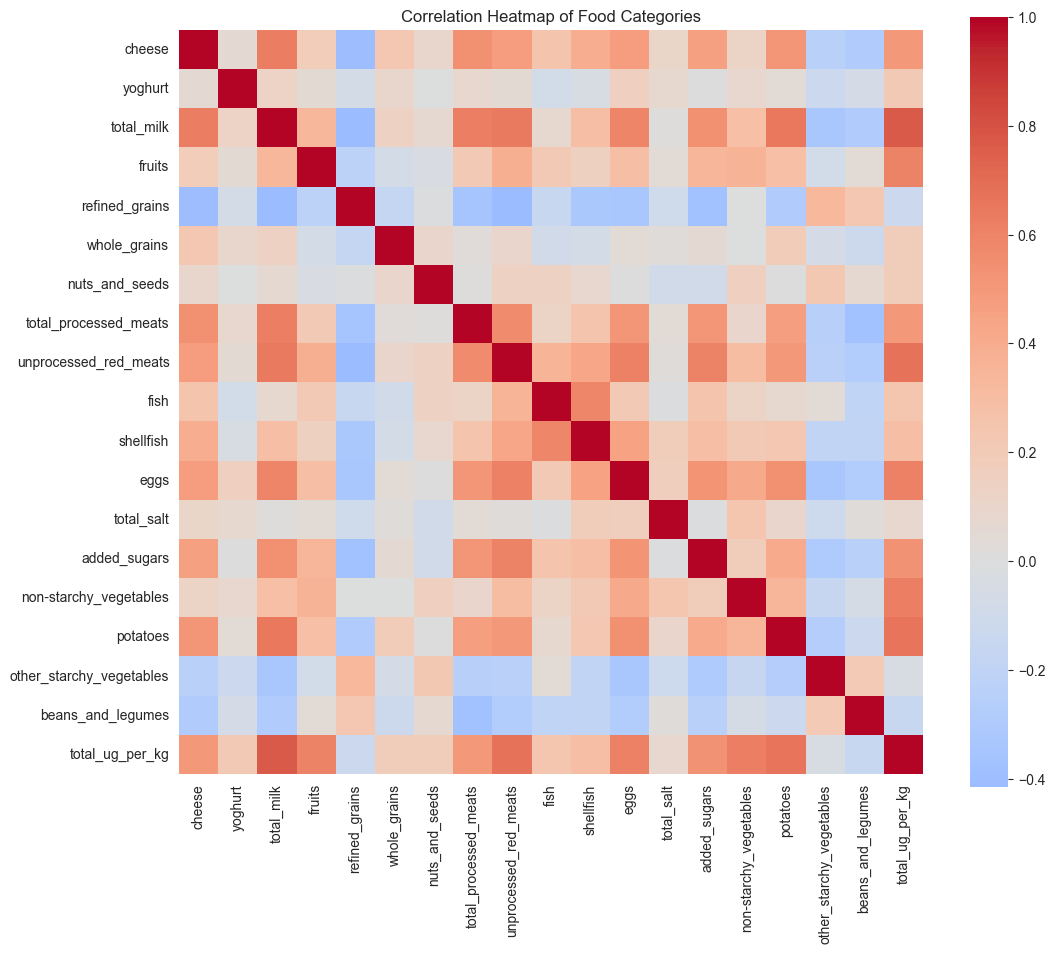

In [118]:
# 4. Correlation structure
plt.figure(figsize=(12, 10))

corr = df[numeric_cols].corr()
print("Correlation matrix:", corr)

sns.heatmap(corr, cmap='coolwarm', center=0, square=True)
plt.title("Correlation Heatmap of Food Categories")
plt.show()

---

**Relationships (Correlation Heatmap) Interpretation:**

1. Strong positive correlations:

    - Refined Grains ↔ Whole Grains: Possibly indicating similar processing or dietary grouping.

    - Total Milk ↔ Yoghurt: Logical, as both are dairy-based.

    - Processed ↔ Unprocessed Meats: Similar protein-based food group.

2. Weak or negative correlations:

    - Cheese, Beans & Legumes have weaker ties to others, potentially due to niche consumption or measurement variation.

    - Total Ug Per Kg shows mild positive correlations with many features but not a strong driver from any single food group.

---

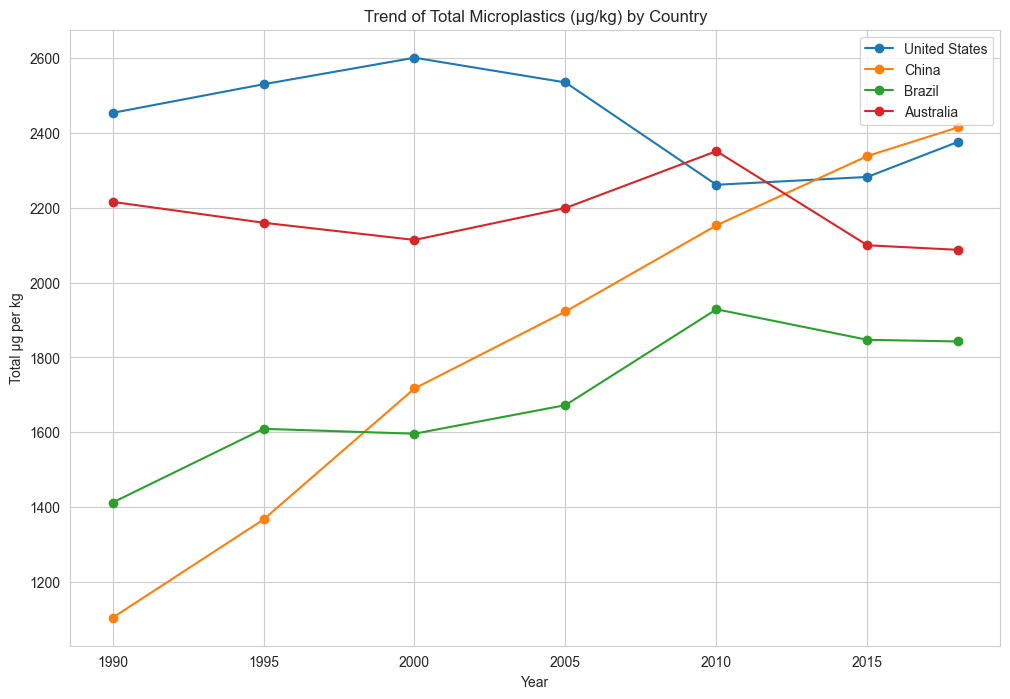

In [119]:
# 5. Time-series trends: Total μg/kg for a few sample countries
sample_countries = ['United States', 'China', 'Brazil', 'Australia']  # adjust as needed

plt.figure(figsize=(12, 8))

for country in sample_countries:
    ts = (df[df['country'] == country]
          .groupby('year')['total_ug_per_kg']
          .mean()
          .reset_index())
    plt.plot(ts['year'], ts['total_ug_per_kg'], marker='o', label=country)

plt.title("Trend of Total Microplastics (μg/kg) by Country")
plt.xlabel("Year")
plt.ylabel("Total μg per kg")
plt.legend()
plt.show()

### **Section 5. Feature Engineering & EDA on Transformed Data**

In [120]:
# 1. Log‑Transform Skewed Features: Applying log1p (i.e.log(1+x)) to the skewed features (e.g., 𝑥0 this will compress the long right‐tails and make the distributions more Gaussian‑like.
# This is particularly useful for features that are highly skewed, as it can help to stabilize variance and make the data more normally distributed.

df_log = df.copy()
log_cols = numeric_cols  # this includes each food category; exclude 'year'

for col in log_cols:
    df_log[col] = np.log1p(df_log[col])

In [121]:
df.isnull().sum()  # Check for any remaining missing values

year                        0
country                     0
cheese                      0
yoghurt                     0
total_milk                  0
fruits                      0
refined_grains              0
whole_grains                0
nuts_and_seeds              0
total_processed_meats       0
unprocessed_red_meats       0
fish                        0
shellfish                   0
eggs                        0
total_salt                  0
added_sugars                0
non-starchy_vegetables      0
potatoes                    0
other_starchy_vegetables    0
beans_and_legumes           0
total_ug_per_kg             0
dtype: int64

---

We have picked **`log1p(x) = log(1 + x)`** for three simple reasons:

1. **Zero‑Safety**

   * Ordinary `log(x)` blows up at zero. Shifting by 1 means even true zero readings become `log1p(0)=0`, so no need for arbitrary small‐value hacks.

2. **Numerical Stability for Small x**

   * When x ≪ 1, `log1p(x)` uses a more accurate Taylor‐series expansion under the hood, avoiding precision errors that a naïve `log(1 + x)` can introduce.

3. **Interpretability & Standard Practice**

   * Most ML and statistics libraries expect natural logs.
   * A one‑unit increase in `log1p(x)` still corresponds to a clear multiplicative effect on the original scale, and it’s widely used any time you have non‑negative data with zeros.

Other variants—like adding a tiny epsilon (`log(x + ε)`) or inverting (`log(1/x)`)—are either ad‑hoc or don’t solve the zero problem as cleanly. `log1p` is the established, numerically sound choice whenever you need to log‑transform data that can include zeros.

---

In [122]:
skew_before = df[numeric_cols].skew().sort_values(ascending=False)
print("Top 5 skew before log:\n", skew_before.head())

Top 5 skew before log:
 yoghurt                     5.161464
shellfish                   3.883391
other_starchy_vegetables    3.271389
cheese                      2.321444
beans_and_legumes           2.232854
dtype: float64


In [123]:
skew_after  = df_log[numeric_cols].skew().sort_values(ascending=False)
print("Top 5 skew after log:\n",  skew_after.head())

Top 5 skew after log:
 cheese                      0.806656
shellfish                   0.697847
other_starchy_vegetables    0.349596
refined_grains             -0.167770
yoghurt                    -0.173251
dtype: float64


---

**Interpretation of Skewness Results:**

Overall, Strong reduction in skew across all categories:

- Before log‑transform, skew ranged as high as ~5.16 (Yoghurt) and ~3.88 (Shellfish), indicating heavy right tails and extreme outliers.

- After log1p, the highest skew is ~0.81 (Cheese) and ~0.70 (Shellfish), with several categories now slightly negatively skewed (e.g. Yoghurt at –0.17).

The log1p transform has successfully “Gaussianized” your feature distributions—no category shows excessive skew (>1).

---

In [124]:
# 2. PCA for Hidden Structure: We’ll standardize the log‐transformed features, fit PCA, and inspect the variance explained to see how many components capture most of the variation.
# 2.1. Standardize
X = df_log[log_cols]
scaler = StandardScaler()
scaler

StandardScaler()

In [125]:
X_scaled = scaler.fit_transform(X)

In [126]:
# 2.2. Fit PCA
pca = PCA(n_components=len(log_cols))  # or set n_components=10 to start
pca

PCA(n_components=19)

In [127]:
X_pca = pca.fit_transform(X_scaled)

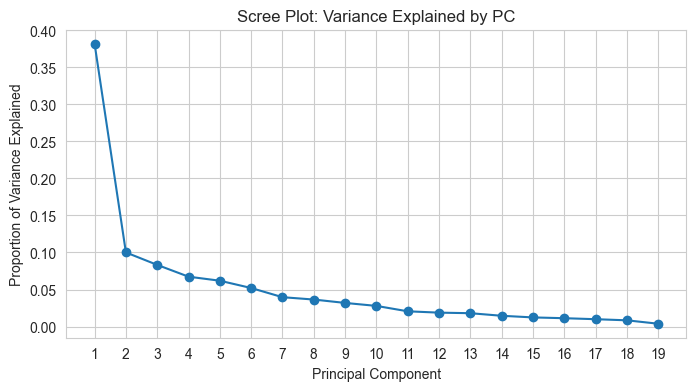

In [128]:
# 2.3. Scree plot (variance explained)
explained = pca.explained_variance_ratio_
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(explained)+1), explained, marker='o')
plt.title("Scree Plot: Variance Explained by PC")
plt.xlabel("Principal Component")
plt.ylabel("Proportion of Variance Explained")
plt.xticks(range(1, len(explained)+1))
plt.show()

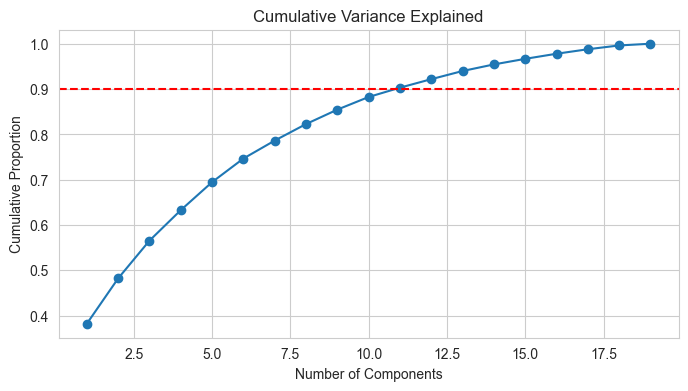

In [129]:
# 2.4. Cumulative variance Graph
cumvar = np.cumsum(explained)
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(cumvar)+1), cumvar, marker='o')
plt.axhline(0.90, color='red', linestyle='--')
plt.title("Cumulative Variance Explained")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Proportion")
plt.show()

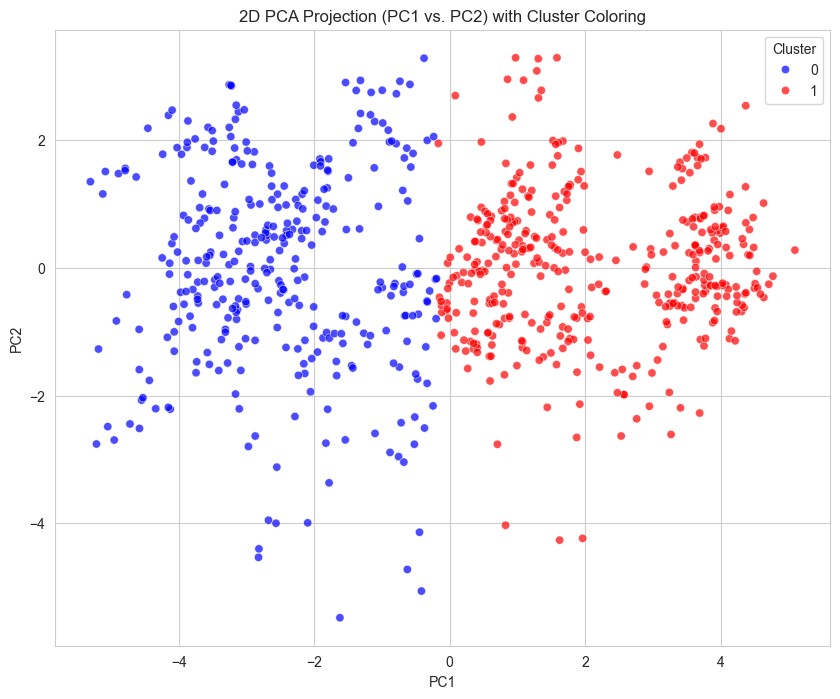

In [130]:
# 2.5. 2D scatter plot
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=42)
cluster_labels = kmeans.fit_predict(X_pca[:, :2])

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    hue=cluster_labels,
    palette=['blue', 'red'],
    alpha=0.7,
    legend='full'
)
plt.title("2D PCA Projection (PC1 vs. PC2) with Cluster Coloring")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Cluster")
plt.show()

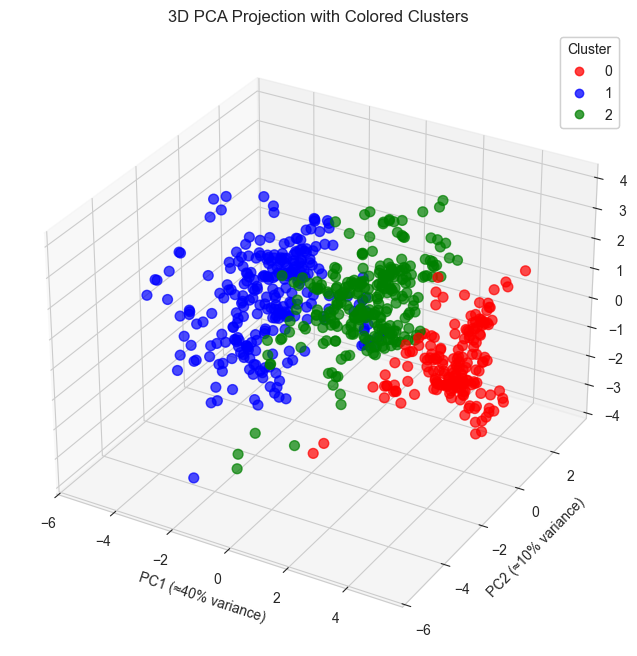

In [131]:
#2.6. 3D scatter plot
from matplotlib.colors import ListedColormap

PC1 = X_pca[:, 0]
PC2 = X_pca[:, 1]
PC3 = X_pca[:, 2]

kmeans_3d = KMeans(n_clusters=3, random_state=50)
labels_3d = kmeans_3d.fit_predict(X_pca[:, :3])

cmap = ListedColormap(['red', 'blue', 'green'])

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    PC1, PC2, PC3,
    c=labels_3d,
    cmap=cmap,
    alpha=0.7,
    s=50
)

ax.set_xlabel('PC1 (≈40% variance)')
ax.set_ylabel('PC2 (≈10% variance)')
ax.set_zlabel('PC3 (≈5% variance)')
ax.set_title('3D PCA Projection with Colored Clusters')

legend1 = ax.legend(*scatter.legend_elements(), title="Cluster", loc="upper right")
ax.add_artist(legend1)

plt.show()

In [132]:
#2.7. Silhouette score
from sklearn.metrics import silhouette_score
scores = {}
for k in [2, 3, 4]:
    km = KMeans(n_clusters=k, random_state=42).fit(X_pca[:, :3])
    scores[k] = silhouette_score(X_pca[:, :3], km.labels_)
print("Silhouette scores:", scores)


Silhouette scores: {2: np.float64(0.4275086682071077), 3: np.float64(0.36720300178683796), 4: np.float64(0.3410527209863763)}


---

- Interpretation: The silhouette score measures how similar an object is to its own cluster compared to other clusters. The best possible score is 1, and the worst is -1. Higher scores indicate better-defined clusters.

- In this case, the silhouette score is highest for 2 clusters (0.4275), followed by 3 clusters (0.3672), and then 4 clusters (0.3411).  This suggests that, according to the silhouette score, the 2-cluster solution is the most optimal among the three.

---

In [133]:
#2.8. Cluster centroids
centroids = pd.DataFrame(
    kmeans_3d.cluster_centers_,
    columns=['PC1', 'PC2', 'PC3']
)

print(centroids)

        PC1       PC2       PC3
0  3.577573 -0.029144 -0.586526
1 -2.901691  0.127495 -0.315314
2  0.642616 -0.110620  0.697312


---

Interpretation: These centroids tell us where the "center" of each cluster is in the reduced-dimensional space defined by the first three principal components.

- Cluster 0 has a high value for PC1 and a negative value for PC3.
- Cluster 1 has a low (negative) value for PC1.
- Cluster 2 has a moderate value for PC1 and a high value for PC3.

This shows that the clusters are separated along these principal components, indicating that PCA has captured some variance that differentiates the clusters.

---

In [134]:
#2.9. Cluster profiles
df_log['cluster_3d'] = labels_3d
cluster_profiles = (df_log.groupby('cluster_3d')[numeric_cols].mean().round(3))
display(cluster_profiles)

,cheese,yoghurt,total_milk,fruits,refined_grains,whole_grains,nuts_and_seeds,total_processed_meats,unprocessed_red_meats,fish,shellfish,eggs,total_salt,added_sugars,non-starchy_vegetables,potatoes,other_starchy_vegetables,beans_and_legumes,total_ug_per_kg
cluster_3d,,,,,,,,,,,,,,,,,,,
0,2.833,3.657,6.277,5.513,5.210,4.520,2.689,4.401,5.066,3.848,2.500,3.429,2.079,4.921,5.596,5.096,0.944,2.122,7.699
1,0.326,3.207,3.703,4.323,5.847,3.590,2.321,2.540,3.385,3.134,0.542,1.409,1.977,3.484,4.726,2.317,3.677,2.902,6.986
2,1.124,3.537,5.158,5.342,5.725,3.347,2.039,3.420,4.469,3.242,1.272,2.936,2.056,4.547,5.473,4.006,2.035,2.893,7.392


---

**Interpretation: Let's analyze this table to understand the dietary patterns of each cluster:**

- Cluster 0:
    - High values for total_milk, fruits, refined_grains, unprocessed_red_meats, non-starchy_vegetables, potatoes, and total_ug_per_kg.
    - This cluster seems to represent a group with a relatively high consumption across many food categories, including milk products, grains, meats, and vegetables, and also higher microplastic contamination.
- Cluster 1:
    - Lower values for cheese, total_processed_meats, unprocessed_red_meats, fish, shellfish, eggs, total_salt, added_sugars, non-starchy_vegetables, and total_ug_per_kg compared to other clusters.
    - This cluster might represent a group with lower overall consumption of many food items and potentially lower microplastic exposure, except for other_starchy_vegetables.
- Cluster 2:
    - Moderate to high values for most food categories, particularly refined_grains, fruits, and high in total_ug_per_kg.
    - This cluster shows a diet with higher consumption in general, similar to Cluster 0 but with differences in specific categories.

---

---
**Decision making**: 

    - Given the goal of understanding different dietary patterns and their associated microplastic exposure, the 3-cluster solution is likely more valuable despite the slightly lower silhouette score.

    - The silhouette score is just one metric. In clustering, interpretability and the ability to extract meaningful insights are often prioritized, especially in exploratory data analysis.

    - The cluster profiles reveal that the 3 clusters have different dietary habits and microplastic exposure levels, which could be important for your project's objectives.

---

In [135]:
#3. KMeans Clustering for Regime Detection

#3.1. Apply KMeans with 3 clusters on first 3 PCs
X3 = X_pca[:, :3]
k3 = KMeans(n_clusters=3, random_state=50)
regime_labels_3 = k3.fit_predict(X3)

#3.2. Attach the new regime labels to the DataFrame
df_log['regime_3'] = regime_labels_3

#3.3. Count the number of samples in each cluster
regime_3_counts = df_log['regime_3'].value_counts()

#3.4. Create cluster profiles for each cluster in regime_3
cluster_profiles_3 = (df_log.groupby('regime_3')[numeric_cols].mean().round(2))

regime_3_counts, cluster_profiles_3

(regime_3
 1    276
 2    272
 0    175
 Name: count, dtype: int64,
           cheese  yoghurt  total_milk  fruits  refined_grains  whole_grains  nuts_and_seeds  total_processed_meats  unprocessed_red_meats  fish  shellfish  eggs  total_salt  added_sugars  non-starchy_vegetables  potatoes  other_starchy_vegetables  beans_and_legumes  total_ug_per_kg
 regime_3                                                                                                                                                                                                                                                                                  
 0           2.83     3.66        6.28    5.51            5.21          4.52            2.69                   4.40                   5.07  3.85       2.50  3.43        2.08          4.92                    5.60      5.10                      0.94               2.12             7.70
 1           0.33     3.21        3.70    4.32            5.85          3.59    

In [136]:
#3.5. Compute the overall mean for each cluster
cluster_means = cluster_profiles_3.mean(axis=1)
cluster_means

regime_3
0    4.126842
1    3.179474
2    3.685263
dtype: float64

In [137]:
#3.6. Sort the clusters by overall mean
sorted_labels = cluster_means.sort_values().index
sorted_labels

Index([1, 2, 0], dtype='int32', name='regime_3')

In [138]:
#3.7. Map sorted labels to human-readable regime names
regime_mapping = {
    sorted_labels[0]: 'Low',
    sorted_labels[1]: 'Medium',
    sorted_labels[2]: 'High'
}

#3.8. Apply mapping to your dataframe
df_log['regime'] = df_log['regime_3'].map(regime_mapping)
df_log

,year,country,cheese,yoghurt,total_milk,fruits,refined_grains,whole_grains,nuts_and_seeds,total_processed_meats,unprocessed_red_meats,fish,shellfish,eggs,total_salt,added_sugars,non-starchy_vegetables,potatoes,other_starchy_vegetables,beans_and_legumes,total_ug_per_kg,cluster_3d,regime_3,regime
0,1990,Angola,0.175449,4.023560,4.580906,4.350543,6.178560,3.813524,1.347895,3.168429,3.118545,3.989238,0.152192,0.713487,2.197809,3.512976,4.396477,2.209328,3.697405,3.036664,6.951082,1,1,Low
1,1990,Benin,0.053346,2.338526,2.965838,4.520448,6.282747,3.908744,3.023427,2.891386,2.740103,2.985405,1.603943,1.347895,1.924905,2.224253,4.820171,0.000000,5.723272,3.099105,7.125006,1,1,Low
2,1990,Burkina Faso,0.242140,3.594311,4.043532,3.004597,5.366771,4.870730,3.383229,2.355304,3.553579,1.737819,0.000000,2.049900,2.070448,2.354632,4.186120,1.169126,2.693331,3.512159,6.503695,1,1,Low
3,1990,Central African Republic,0.000000,3.006003,3.891820,4.739677,5.656115,5.715605,3.198953,3.310984,3.994276,2.702556,0.000000,0.752966,2.026182,3.030068,4.632332,0.454473,5.349258,2.626256,7.121527,1,1,Low
4,1990,Cote D'Ivoire,0.263417,1.169520,3.666368,3.637947,6.082008,3.266536,2.885030,1.241009,4.058430,3.959377,0.400888,1.234993,2.366584,3.382298,5.024871,1.080179,6.518521,1.210799,7.340513,1,1,Low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
718,2018,Ukraine,1.409984,5.290626,6.075409,5.211580,5.644936,4.715632,2.134410,4.397149,4.198543,3.409836,1.362030,3.882270,2.115531,5.113554,6.150077,5.896363,0.000000,1.641786,7.804110,0,0,High
719,2018,Uruguay,1.766325,4.533832,6.267720,5.404712,5.908289,3.695067,1.587276,3.989043,4.664700,3.129520,1.455744,3.480608,2.002406,5.022889,5.108433,4.361439,3.931288,2.218310,7.564173,2,2,Medium
720,2018,United States,2.024899,3.381760,6.446958,5.657571,5.487916,3.788646,3.240557,4.970959,5.328936,3.545120,3.344361,3.815753,2.225299,5.180012,5.750396,4.971049,2.530648,2.439365,7.773582,0,0,High
721,2018,Venezuela,0.284252,3.216493,5.541908,5.266516,5.554907,2.695638,0.175449,3.698089,4.237670,3.186579,1.647077,2.743928,1.923258,4.440069,4.925565,3.685793,4.199774,2.665133,7.120892,2,2,Medium


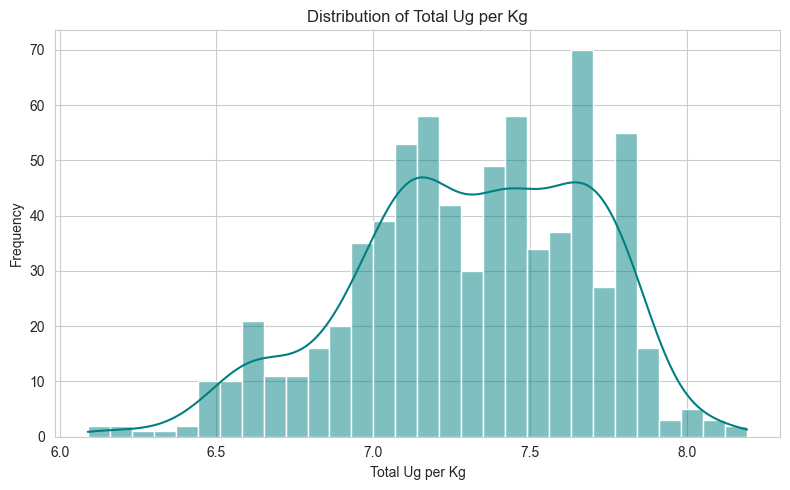

In [139]:
#3.8.1. Distribution of the Target Variable
plt.figure(figsize=(8, 5))
sns.histplot(df_log['total_ug_per_kg'], kde=True, color='teal', bins=30)
plt.title('Distribution of Total Ug per Kg')
plt.xlabel('Total Ug per Kg')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

---

**Interpretation**:
- This histogram shows the distribution of your target variable, 'total_ug_per_kg'.

- The distribution appears to be somewhat multi-modal or at least skewed, with a primary peak around 7.6 and a secondary peak around 7.1.

- The KDE (Kernel Density Estimate) line provides a smoother representation of the distribution.

- This visualization helps understand the range and typical values of microplastic concentration in your dataset.

---

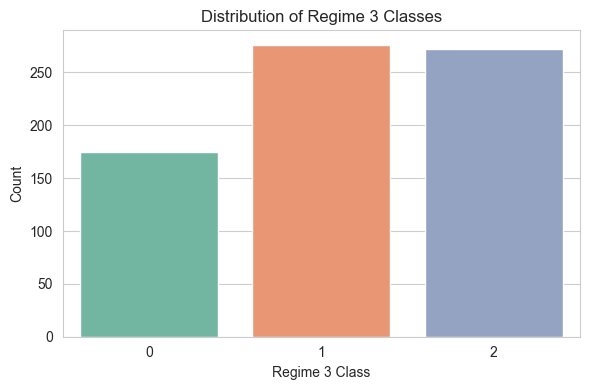

In [140]:
#3.8.2. Distribution of Regime Classes
plt.figure(figsize=(6, 4))
sns.countplot(data=df_log, x='regime_3', palette='Set2')
plt.title('Distribution of Regime 3 Classes')
plt.xlabel('Regime 3 Class')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

---

**Interpretation**: 
- This bar plot shows the number of data points in each of the three clusters you identified ('regime_3').

- As we saw from the value_counts() output earlier, the clusters have sizes of approximately 175, 276, and 272.

- This visualization confirms the relatively balanced distribution of samples across the three regimes.

---

In [141]:
#3.9. Correlation Analysis
# Compute correlation matrix
corr_matrix = df_log.corr(numeric_only=True)
corr_matrix = corr_matrix.drop('total_ug_per_kg').drop('year', axis=1)
corr_matrix

,cheese,yoghurt,total_milk,fruits,refined_grains,whole_grains,nuts_and_seeds,total_processed_meats,unprocessed_red_meats,fish,shellfish,eggs,total_salt,added_sugars,non-starchy_vegetables,potatoes,other_starchy_vegetables,beans_and_legumes,total_ug_per_kg,cluster_3d,regime_3
year,0.059585,0.026635,-0.060343,0.076617,0.067032,0.044560,0.092909,0.110550,0.139635,0.118605,0.091261,0.143716,0.040894,0.202398,0.160635,0.123741,0.030251,0.037884,0.142730,0.003346,0.003346
cheese,1.000000,0.126658,0.701827,0.402535,-0.502754,0.320211,0.166502,0.576756,0.594915,0.235024,0.531888,0.625963,0.139265,0.624640,0.388760,0.637883,-0.584301,-0.342398,0.615547,-0.492819,-0.492819
yoghurt,0.126658,1.000000,0.182759,0.140799,-0.079583,-0.016520,-0.076426,0.199689,0.107184,-0.172339,-0.022472,0.171479,0.051915,0.079818,0.073189,0.109218,-0.234208,-0.074198,0.192631,-0.018772,-0.018772
total_milk,0.701827,0.182759,1.000000,0.413989,-0.450969,0.234013,-0.013968,0.609727,0.627570,-0.035573,0.346647,0.597056,0.034771,0.635996,0.340497,0.679426,-0.556287,-0.185517,0.609095,-0.225114,-0.225114
fruits,0.402535,0.140799,0.413989,1.000000,-0.221065,-0.000418,0.003798,0.385550,0.452177,0.322459,0.407937,0.549066,0.026469,0.466974,0.555275,0.500206,-0.128279,-0.014615,0.699042,0.007458,0.007458
refined_grains,-0.502754,-0.079583,-0.450969,-0.221065,1.000000,-0.163878,-0.029972,-0.352270,-0.431162,-0.180890,-0.437299,-0.359178,-0.096633,-0.350404,-0.065120,-0.329891,0.304989,0.315284,-0.132147,0.394673,0.394673
whole_grains,0.320211,-0.016520,0.234013,-0.000418,-0.163878,1.000000,0.183591,0.235667,0.146476,-0.060917,-0.044124,0.038699,-0.056980,0.159495,0.015351,0.184861,-0.157075,-0.151818,0.306408,-0.346036,-0.346036
nuts_and_seeds,0.166502,-0.076426,-0.013968,0.003798,-0.029972,0.183591,1.000000,0.074970,0.164009,0.322869,0.163367,0.103772,-0.005065,-0.025301,0.221799,-0.066855,0.058736,-0.063045,0.239523,-0.297366,-0.297366
total_processed_meats,0.576756,0.199689,0.609727,0.385550,-0.352270,0.235667,0.074970,1.000000,0.685976,0.174360,0.398272,0.553335,-0.057086,0.620862,0.235373,0.441809,-0.370325,-0.404251,0.552217,-0.271435,-0.271435
unprocessed_red_meats,0.594915,0.107184,0.627570,0.452177,-0.431162,0.146476,0.164009,0.685976,1.000000,0.299516,0.565914,0.689061,0.028005,0.661803,0.406248,0.509153,-0.307793,-0.329851,0.658405,-0.164050,-0.164050


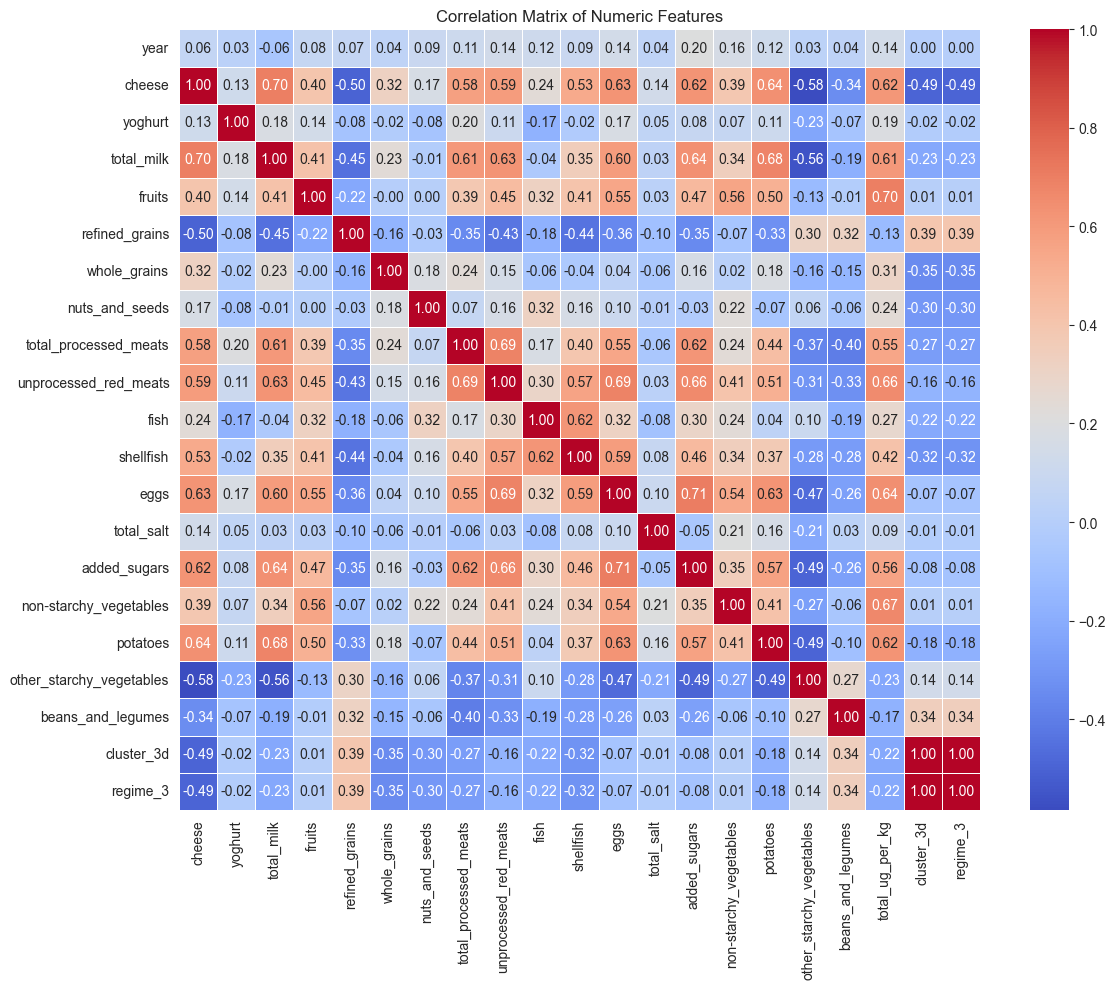

In [142]:
# Display correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Numeric Features')
plt.tight_layout()
plt.show()

---

**Interpretation**:

- The heatmap displays the correlation coefficients between different numerical features in your dataset, including the 'cluster_3d' and 'regime_3' columns.

- By examining the last two rows/columns ('cluster_3d' and 'regime_3'), you can see how these cluster assignments correlate with the original food consumption variables and the target variable ('total_ug_per_kg').

- This can provide insights into which food categories or other factors are most strongly associated with the different clusters. For example, you might observe that certain food groups have a higher positive correlation with the 'High' regime.

---

### **Section 6. Advanced Feature Engineering**

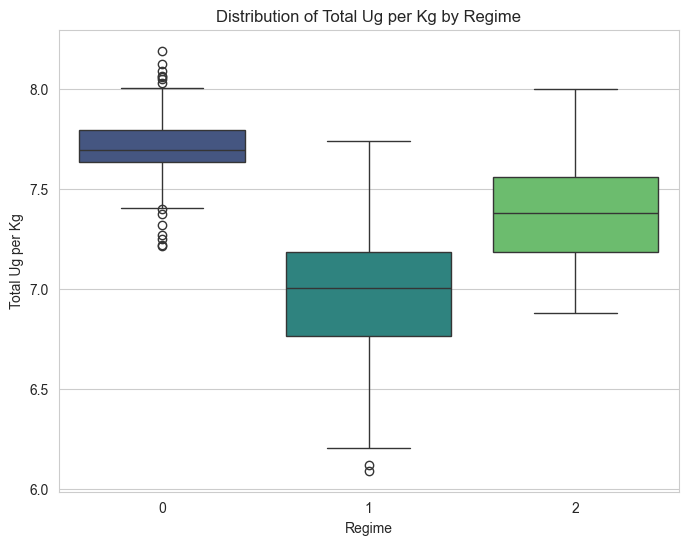

In [143]:
# 1. Visualize 'total_ug_per_kg' by Regime

plt.figure(figsize=(8, 6))
sns.boxplot(data=df_log, x='regime_3', y='total_ug_per_kg', palette='viridis')
plt.title('Distribution of Total Ug per Kg by Regime')
plt.xlabel('Regime')
plt.ylabel('Total Ug per Kg')
plt.show()

### **Statistical Tests: ANOVA and Tukey's HSD**

We conduct an ANOVA test to determine if there are statistically significant differences in the mean 'total_ug_per_kg' (microplastic concentration) across the identified dietary regimes ('regime_3'). If the ANOVA test yields a significant p-value (typically < 0.05), it indicates that at least one regime has a mean 'total_ug_per_kg' that is significantly different from the others.

Following a significant ANOVA result, we perform Tukey's Honestly Significant Difference (HSD) post-hoc test. This test allows us to identify which specific pairs of dietary regimes have statistically significant differences in their mean 'total_ug_per_kg', while controlling for multiple comparisons.

In [144]:
# Import necessary libraries
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [145]:
#2.1 Perform ANOVA to check for significant differences in 'total_ug_per_kg' across regimes
formula_ug = 'total_ug_per_kg ~ C(regime_3)'
model_ug = ols(formula_ug, data=df_log).fit()
anova_table_ug = sm.stats.anova_lm(model_ug, typ=2)
print(anova_table_ug)

                sum_sq     df           F         PR(>F)
C(regime_3)  57.334769    2.0  452.438987  5.549170e-128
Residual     45.620553  720.0         NaN            NaN


---

**Extended Information:**

- C(regime_3): This row refers to the effect of the dietary regimes on 'total_ug_per_kg'.

- sum_sq: This is the sum of squares, representing the variability explained by the regimes.

- df: This is the degrees of freedom (2 for regimes, 720 for residuals).

- F: This is the F-statistic, a measure of the ratio of variance between groups to variance within groups. A large F-statistic suggests that the group means are different.

- PR(>F): This is the p-value. It represents the probability of observing the data if there were truly no difference in the means of 'total_ug_per_kg' across the regimes.

---

In [146]:
#2.2 Perform Tukey's HSD post-hoc test if ANOVA is significant (alpha=0.05)
alpha = 0.05
if anova_table_ug['PR(>F)']['C(regime_3)'] < alpha:
    tukey_result = pairwise_tukeyhsd(df_log['total_ug_per_kg'], df_log['regime_3'], alpha=alpha)
    print('\n', tukey_result)


 Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
     0      1  -0.7133   0.0 -0.7704 -0.6562   True
     0      2  -0.3069   0.0 -0.3642 -0.2496   True
     1      2   0.4063   0.0  0.3558  0.4569   True
---------------------------------------------------


---

**Extended Information:**

- group1, group2: These columns show the pairs of regimes being compared (0, 1, and 2).

- meandiff: This is the difference between the mean 'total_ug_per_kg' for the two regimes.

- p-adj: This is the adjusted p-value, corrected for multiple comparisons.

- lower, upper: These are the lower and upper bounds of the confidence interval for the mean difference.

- reject: This is a boolean indicating whether the null hypothesis (that the means are equal) is rejected. True means the means are significantly different.

---

---

**Conclusions and Interpretations:**

- ANOVA Conclusion: The ANOVA test shows a highly significant effect of the dietary regimes on 'total_ug_per_kg' (F = 452.44, p < 0.0001). This indicates that there are statistically significant differences in the average microplastic concentration across at least two of the regimes.

- Tukey's HSD Conclusions:
    - Regime 0 has a significantly higher average 'total_ug_per_kg' than Regime 1 (mean difference = -0.7133, p < 0.0001).
    - Regime 1 also has a significantly higher average 'total_ug_per_kg' than Regime 2 (mean difference = -0.3069, p < 0.0001).
    - Regime 2 also has a significantly higher average 'total_ug_per_kg' than Regime 1 (mean difference = 0.4063, p < 0.0001).


**In simpler terms:**
The statistical tests confirm that the dietary regimes you identified are associated with different levels of microplastic contamination. Specifically, Regime 0 has the highest average microplastic concentration, followed by Regime 2, and then Regime 1. The differences between all three regimes are statistically significant.

---

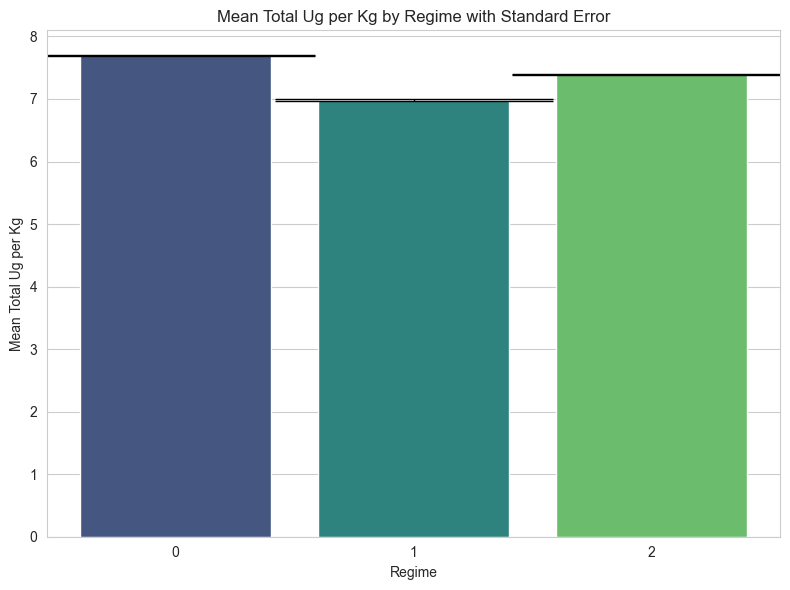

In [147]:
# 3. Visualize the mean and standard error of 'total_ug_per_kg' by regime

# Calculate the mean and standard error of 'total_ug_per_kg' for each regime
regime_means = df_log.groupby('regime_3')['total_ug_per_kg'].mean()
regime_errors = df_log.groupby('regime_3')['total_ug_per_kg'].sem()  # Standard error of the mean

# Create the bar chart with error bars
plt.figure(figsize=(8, 6))
bars = sns.barplot(x=regime_means.index, y=regime_means.values, palette='viridis')
plt.errorbar(
    x=regime_means.index,
    y=regime_means.values,
    yerr=regime_errors.values,
    fmt='none',
    color='black',
    capsize=100,
    linewidth=1,
)

plt.title('Mean Total Ug per Kg by Regime with Standard Error')
plt.xlabel('Regime')
plt.ylabel('Mean Total Ug per Kg')
plt.xticks(rotation=0)  # Rotate x-axis labels if needed
plt.tight_layout()
plt.show()

---

**Interpretation of the Bar Chart:**

The bar chart visually confirms the statistical findings. Regime 0 exhibits the highest mean 'total_ug_per_kg', followed by Regime 2, and Regime 1 shows the lowest average microplastic concentration. The error bars (representing the standard error of the mean) indicate the variability within each regime. Since the error bars for the different regimes do not overlap substantially, it further supports the conclusion that the mean microplastic levels are indeed different across the dietary patterns.

---

### **Section 7. Data Modelling**

**Predicting Microplastic Levels Based on Dietary Regimes**

In this section, we transition from exploratory data analysis and statistical inference to predictive modeling. Our goal is to build machine learning models that can predict the level of microplastic contamination ('total_ug_per_kg') based on the identified dietary regimes ('regime_3'). The dietary regime, derived from clustering analysis of food consumption patterns, will serve as a key categorical predictor.

We will explore and evaluate several regression models, including:

1.  **Linear Regression:** A foundational model assuming a linear relationship between the predictor and the target.

2.  **Polynomial Regression:** An extension of linear regression that can capture non-linear relationships by introducing polynomial features.

3.  **Decision Tree Regressor:** A non-parametric model that learns decision rules from the data to make predictions. It can handle categorical features without requiring explicit encoding.

4.  **Random Forest Regressor:** An ensemble learning method that builds multiple decision trees and averages their predictions to improve robustness and accuracy.

5.  **XGBoost Regressor:** An optimized gradient boosting algorithm known for its high performance and flexibility in handling complex datasets.

For each model, we will follow a standard machine learning workflow: data preparation, model training, prediction, and performance evaluation. By comparing the performance metrics of these different models, we aim to identify the most suitable approach for predicting microplastic levels based on dietary patterns. The best-performing model will then be considered for integration into the web application designed for this project.

In [148]:
feature_cols = [
    'cheese', 'yoghurt', 'total_milk', 'fruits', 'refined_grains',
    'whole_grains', 'nuts_and_seeds', 'total_processed_meats',
    'unprocessed_red_meats', 'fish', 'shellfish', 'eggs', 'total_salt',
    'added_sugars', 'non-starchy_vegetables', 'potatoes',
    'other_starchy_vegetables', 'beans_and_legumes'
]

In [149]:
# Prepare the data for modeling
# Select features and target variable
X = df_log[feature_cols]
y = df_log['total_ug_per_kg']

In [150]:
# First, split off the test set (20%)
X_train, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=50)

# Now split the remaining 80% into train (70%) and validation (10%)
# 10% out of 80% is 12.5% of the original data
X_train, X_val, y_train, y_val = train_test_split(X_train, y_temp, test_size=0.125, random_state=50)

print(f"Train set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")

Train set: (505, 18)
Validation set: (73, 18)
Test set: (145, 18)


### **1. Linear Regression Model**

In [151]:
lr = LinearRegression()
lr

LinearRegression()

In [152]:
lr.fit(X_train, y_train)

LinearRegression()

In [153]:
# Predict on validation and test sets as needed:
y_pred_val_lr = lr.predict(X_val)
y_pred_test_lr = lr.predict(X_test)

### **2. Polynomial Regression Model**

In [154]:
poly = PolynomialFeatures(degree=2)
poly

PolynomialFeatures()

In [155]:
X_train_poly = poly.fit_transform(X_train)
X_val_poly = poly.transform(X_val)
X_test_poly = poly.transform(X_test)

In [156]:
pr = LinearRegression()
pr

LinearRegression()

In [157]:
pr.fit(X_train_poly, y_train)

LinearRegression()

In [158]:
y_pred_val_pr = pr.predict(X_val_poly)
y_pred_test_pr = pr.predict(X_test_poly)

### **3. Decision Tree Regressor Model**

In [159]:
from sklearn.tree import DecisionTreeRegressor
dt = DecisionTreeRegressor(random_state=50)
dt

DecisionTreeRegressor(random_state=50)

In [160]:
dt.fit(X_train, y_train)

DecisionTreeRegressor(random_state=50)

In [161]:
y_pred_val_dt = dt.predict(X_val)
y_pred_test_dt = dt.predict(X_test)

### **4. Random Forest Model**

In [162]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=50, max_depth=100)
rf

RandomForestRegressor(max_depth=100, random_state=50)

In [163]:
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=100, random_state=50)

In [164]:
y_pred_val_rf = rf.predict(X_val)
y_pred_test_rf = rf.predict(X_test)

### **5. Gradient Boost  Regressor (XGBoost Model):**

In [165]:
from xgboost import XGBRegressor

xgb = XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=50, max_depth=10, learning_rate=0.1)
xgb.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=True)

[0]	validation_0-rmse:0.34815
[1]	validation_0-rmse:0.31783
[2]	validation_0-rmse:0.29400
[3]	validation_0-rmse:0.26997
[4]	validation_0-rmse:0.24823
[5]	validation_0-rmse:0.23049
[6]	validation_0-rmse:0.21411
[7]	validation_0-rmse:0.20052
[8]	validation_0-rmse:0.18531
[9]	validation_0-rmse:0.17306
[10]	validation_0-rmse:0.16188
[11]	validation_0-rmse:0.15274
[12]	validation_0-rmse:0.14389
[13]	validation_0-rmse:0.13624
[14]	validation_0-rmse:0.12871
[15]	validation_0-rmse:0.12217
[16]	validation_0-rmse:0.11638
[17]	validation_0-rmse:0.11160
[18]	validation_0-rmse:0.10717
[19]	validation_0-rmse:0.10300
[20]	validation_0-rmse:0.09967
[21]	validation_0-rmse:0.09624
[22]	validation_0-rmse:0.09333
[23]	validation_0-rmse:0.09061
[24]	validation_0-rmse:0.08801
[25]	validation_0-rmse:0.08579
[26]	validation_0-rmse:0.08382
[27]	validation_0-rmse:0.08208
[28]	validation_0-rmse:0.08045
[29]	validation_0-rmse:0.07911
[30]	validation_0-rmse:0.07776
[31]	validation_0-rmse:0.07667
[32]	validation_0-

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [166]:
y_pred_val_xgb = xgb.predict(X_val)
y_pred_test_xgb = xgb.predict(X_test)

### **Section 8. Model Evaluation and Selection**

**Model Evaluation Metrics Used:**

To assess and compare models, several standard metrics ared used. These metrics help in evaluating the performance of the model and its behaviour on the dataset.

- **MAE (Mean Absolute Error):**  
  The average absolute difference between predicted and actual values.  
  **Lower MAE is better**-it means predictions are closer to the true values on average.

- **MSE (Mean Squared Error):**  
  The average of squared differences between predicted and actual values.  
  **Lower MSE is better**-it penalizes larger errors more, so a high MSE indicates some predictions are far off.

- **RMSE (Root Mean Squared Error):**  
  The square root of MSE, in the same units as the target variable.  
  **Lower RMSE is better**-it reflects the typical size of prediction errors, with larger errors weighted more heavily.

- **R² (R-squared):**  
  The proportion of variance in the target explained by the model (ranges from 0 to 1, can be negative if the model is poor).  
  **Higher R² is better**-a value close to 1 means the model explains most of the variance.

- **Adjusted R²:**  
  Like R², but adjusts for the number of predictors, discouraging overfitting.  
  **Higher Adjusted R² is better**-it rewards models that improve fit without unnecessary complexity.

- **MAPE (Mean Absolute Percentage Error):**  
  The average absolute percent error between predicted and actual values.  
  **Lower MAPE is better**-it’s useful for understanding errors in relative terms.

**Why use these metrics?**  
Together, these metrics give a comprehensive view of model accuracy and reliability. Lower values of MAE, MSE, RMSE, and MAPE mean better predictions, while higher R² and Adjusted R² indicate the model explains more of the data’s variation. This helps to choose the model that best balances accuracy and generalizability for predicting microplastic contamination levels.

In [167]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def adjusted_r2(y_true, y_pred, n_features):
    r2 = r2_score(y_true, y_pred)
    n = len(y_true)
    return 1 - (1 - r2) * (n - 1) / (n - n_features - 1)

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

n_features = X_test.shape[1] if len(X_test.shape) > 1 else 1

metrics = []
for model_name, y_pred in [
    ("Linear Regression", y_pred_test_lr),
    ("Polynomial Regression", y_pred_test_pr),
    ("Decision Tree", y_pred_test_dt),
    ("Random Forest", y_pred_test_rf),
    ("XGBoost", y_pred_test_xgb)
]:
    mae = round(mean_absolute_error(y_test, y_pred), 4)
    mse = round(mean_squared_error(y_test, y_pred), 4)
    rmse = round(np.sqrt(mse), 4)
    r2 = round(r2_score(y_test, y_pred), 4)
    adj_r2 = round(adjusted_r2(y_test, y_pred, n_features), 4)
    mape = round(mean_absolute_percentage_error(y_test, y_pred), 4)
    metrics.append([model_name, mae, mse, rmse, r2, adj_r2, mape])

metrics_df = pd.DataFrame(metrics, columns=[
    "Model", "MAE", "MSE", "RMSE", "R2", "Adjusted R2", "MAPE (%)"
])

print(metrics_df)


                   Model     MAE     MSE    RMSE      R2  Adjusted R2  MAPE (%)
0      Linear Regression  0.0872  0.0141  0.1187  0.8726       0.8544    1.1989
1  Polynomial Regression  0.0243  0.0011  0.0332  0.9897       0.9883    0.3335
2          Decision Tree  0.0934  0.0200  0.1414  0.8191       0.7933    1.2872
3          Random Forest  0.0530  0.0049  0.0700  0.9559       0.9496    0.7274
4                XGBoost  0.0544  0.0059  0.0768  0.9469       0.9393    0.7526


---

### **Interpretation and Decision Taken:**

Polynomial Regression, Random Forest, and XGBoost models all achieving very strong results. Here’s what the metrics indicate:

- Linear Regression & Decision Tree
    - Linear Regression: Good performance (R² ≈ 0.87, MAE ≈ 0.087), but outperformed by other models.

    - Decision Tree: Slightly higher errors (MAE ≈ 0.093, MAPE ≈ 1.29%) and lower R² (≈ 0.82), indicating it is less accurate and may overfit or underfit compared to ensemble methods.

- Polynomial Regression
    - Polynomial Regression: Outstanding performance (R² ≈ 0.99, MAE ≈ 0.024, MAPE ≈ 0.33%), the lowest error among all models.

    - However, polynomial models can sometimes overfit, especially if the data is not truly polynomial in nature.

- Random Forest & XGBoost
    - Random Forest: Excellent performance (R² ≈ 0.96, MAE ≈ 0.053, MAPE ≈ 0.73%), robust and reliable.

    - XGBoost: Also excellent (R² ≈ 0.95, MAE ≈ 0.054, MAPE ≈ 0.75%), with strong generalization and advanced capabilities.

**Which Model Should We Move Forward With?**
- Polynomial Regression gives the lowest error, but may overfit and is less robust to new/unseen data.

- Random Forest and XGBoost both provide excellent accuracy, generalize well, and are more robust for real-world predictive tasks.

    - Random Forest is easy to interpret and less prone to overfitting than a single decision tree.

    - XGBoost is highly accurate, efficient for large datasets, and offers advanced features like regularization and missing value handling.

Hence, the XGBoost Model was selected for this particular dataset and problem, balancing accuracy, robustness, and scalability for deployment in a production environment.

---

In [168]:
#Save the best model
import joblib

# After fitting your best model (e.g., XGBoost)
joblib.dump(xgb, 'xgboost_microplastic_model.pkl')

# Later, use model.predict(user_input) for predictions:
model = joblib.load('xgboost_microplastic_model.pkl')

### **Section 9. Testing of the Model**

---

In this section, we evaluate the performance of our trained model and generate predictions based on user inputs and historical data. We systematically test the model using various scenarios, analyze the results, and present key findings through clear visualizations and summaries. This process not only helps validate the accuracy and robustness of our approach, but also provides actionable insights into microplastic consumption patterns and the main contributing food categories. The following code blocks detail the steps involved in testing, forecasting, and interpreting the model’s outputs.

---

In [169]:
xgboost_model = model  # Load the trained model

# 9.1 User Input
user_country = 'India'  # Example User chooses from 'USA', 'China', 'Brazil', 'Australia', 'India', 'Germany', 'France' etc...
selected_categories = ['cheese', 'fish', 'eggs', 'total_salt', 'potatoes', 'total_milk', 'total_salt', 'yoghurt', 'total_processed_meats']  # Example user selection

In [170]:
# All 18 food category columns
feature_cols = [
    'cheese', 'yoghurt', 'total_milk', 'fruits', 'refined_grains',
    'whole_grains', 'nuts_and_seeds', 'total_processed_meats',
    'unprocessed_red_meats', 'fish', 'shellfish', 'eggs', 'total_salt',
    'added_sugars', 'non-starchy_vegetables', 'potatoes',
    'other_starchy_vegetables', 'beans_and_legumes'
]

Country: India
Actual 2018 value:    7.1268 ug/kg
Predicted 2018 value: 7.2841 ug/kg
Absolute Error:       0.1573 ug/kg


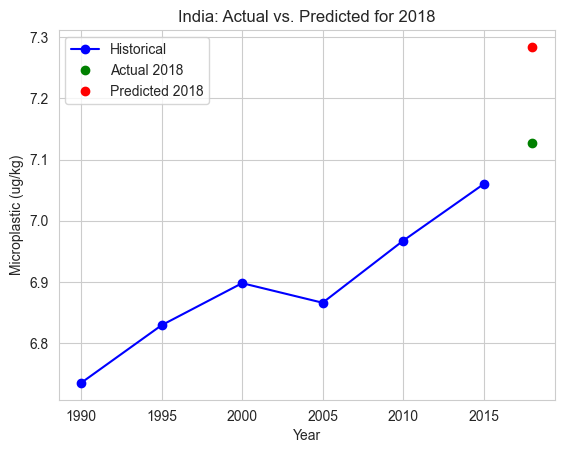

In [199]:
# 9.1.1 Prepare Data
df_log['country'] = df_log['country'].str.strip()
country_df = df_log[df_log['country'] == user_country].sort_values('year')

# 9.1.2 Hold out the data of the year 2018 for validation purposes
train_df = country_df[country_df['year'] < 2018].copy()
test_df = country_df[country_df['year'] == 2018].copy()

# 9.1.3 Check if the user country has data for 2018 and if not, prompt the user to try another country or else load the pre-trained model and continue the prediction
if test_df.empty:
    print(f"No 2018 data for {user_country}. Try another country.")
else:
    xgboost_model = joblib.load('xgboost_microplastic_model.pkl')

    # 9.1.4 Prepare features for prediction
    X_train = train_df[feature_cols]
    y_train = train_df['total_ug_per_kg']
    X_test = test_df[feature_cols]
    y_test = test_df['total_ug_per_kg'].values[0]

    # 9.1.5 Predict value for the year 2018
    y_pred_2018 = model.predict(X_test)[0]

    # 9.1.6 Compare and Report the predicted value with the actual value
    print(f"Country: {user_country}")
    print(f"Actual 2018 value:    {y_test:.4f} ug/kg")
    print(f"Predicted 2018 value: {y_pred_2018:.4f} ug/kg")
    print(f"Absolute Error:       {abs(y_test - y_pred_2018):.4f} ug/kg")

    # 9.1.7 Visualize the results
    plt.plot(train_df['year'], y_train, 'bo-', label='Historical')
    plt.plot(2018, y_test, 'go', label='Actual 2018')
    plt.plot(2018, y_pred_2018, 'ro', label='Predicted 2018')
    plt.xlabel('Year')
    plt.ylabel('Microplastic (ug/kg)')
    plt.title(f'{user_country}: Actual vs. Predicted for 2018')
    plt.legend()
    plt.show()

---

### **Interpretation and Model Performance**

To evaluate the model’s accuracy, we withheld India’s 2018 microplastic consumption data and predicted it using historical data up to 2015. The model predicted a value of 7.28 µg/kg, closely aligning with the actual 2018 value of 7.13 µg/kg, resulting in a low absolute error of 0.16 µg/kg.

The accompanying plot shows the historical trend alongside the actual and predicted 2018 values, illustrating the model’s strong ability to capture underlying patterns. This close match indicates the model generalizes well and provides reliable forecasts for microplastic consumption.

In summary, the model demonstrates robust predictive performance and can be confidently used for future exposure estimations.

---

---

**With our model successfully validated and shown to make close to actual predictions, we now proceed to the next phase: testing its forecasting capabilities and visualizing the results. In this stage, we will use the model to generate future predictions, present the outcomes through clear visualizations, and provide users with concrete, actionable insights to support their studies or findings.**

---

In [171]:
# Fill missing values for each feature column with the median of that feature for each year
for feature in feature_cols:
    df_log[feature] = df_log.groupby('year')[feature].transform(lambda x: x.fillna(x.median()))

In [172]:
# 9.2 Historical Data
historical_years = [1990, 1995, 2000, 2005, 2010, 2015, 2018]
historical_df = df_log[(df_log['country'] == user_country) & (df_log['year'].isin(historical_years))]
historical_years = historical_df['year'].tolist()
historical_values = historical_df['total_ug_per_kg'].tolist()

In [173]:
# 9.3 Forecasting the data
# 9.3.1. Extrapolate the feature values for the selected categories
def extrapolate_feature(country, feature, start_year, end_year, df):
    sub = df[df['country'] == country][['year', feature]].dropna()
    if sub.shape[0] < 2:
        last_val = sub[feature].iloc[-1]
        return [last_val] * (end_year - start_year + 1)
    coeffs = np.polyfit(sub['year'], sub[feature], 1)
    years = np.arange(start_year, end_year + 1)
    return coeffs[0] * years + coeffs[1]

# 9.3.2. Forecasting the feature values for the selected categories
forecast_years = list(range(2019, 2031)) # Forecasting from 2019 to 2030
growth_rate = 0.015  # 1.5% annual increase is a reasonable assumption based on historical data, trends, and research

# 9.3.3. Create a dictionary to store the forecasted values
forecast_features = {}

# 9.3.4. Loop through each feature and calculate the forecasted values
for feature in feature_cols:
    # 9.3.4.1. Find the latest available year for this country and feature
    # Check if the feature is missing for the user_country
    sub = df_log[(df_log['country'] == user_country) & (~df_log[feature].isna())]
    
    #Handle the case where the feature is missing for the user_country
    if sub.empty:
         # Impute Values only if they are missing in the dataframe for specific countries: use the latest year for which any country has a value for this feature
        latest_year = df_log[~df_log[feature].isna()]['year'].max() # ~ was used to filter out NaN values 
        
        # Median for that year across all countries
        median_val = df_log[df_log['year'] == latest_year][feature].median()
        
        if np.isnan(median_val):
            # Fallback: median across all years/countries
            median_val = df_log[feature].median()
        
        base_val = median_val
        print(f"Imputed {feature} for {user_country} with {base_val:.4f} (median for year {latest_year})")
    
    else:
        latest_year = sub['year'].max()
        base_val = sub[sub['year'] == latest_year][feature].values[0]

    # 9.3.4.2. Exponential growth from the latest year
    forecast_features[feature] = [
        base_val * ((1 + growth_rate) ** (year - latest_year)) for year in forecast_years
    ]

# 9.3.5 Build the DataFrame for the forecasted data
forecast_df = pd.DataFrame({'year': forecast_years})
for feature in feature_cols:
    forecast_df[feature] = forecast_features[feature]

In [174]:
# 9.4 Predict the microplastic concentration using the trained model for the forecasted data
forecast_df['Predicted Microplastic (ug/kg)'] = [
    xgboost_model.predict(row[feature_cols].values.reshape(1, -1))[0] # Reshape to 2D for prediction
    for _, row in forecast_df.iterrows() # Using _ to ignore the index and iterrows() to iterate over rows
]

In [175]:
# 9.5 Combine historical and forecasted data for visualization
all_years = historical_years + forecast_years
all_values = historical_values + forecast_df['Predicted Microplastic (ug/kg)'].tolist()

In [176]:
# 9.6 Highlight the Current Year i.e. 2025
highlight_year = 2025
highlight_value = forecast_df[forecast_df['year'] == highlight_year]['Predicted Microplastic (ug/kg)'].values[0]

In [177]:
if not historical_years or not historical_values:
    print(f"No historical data found for {user_country} in the specified years: {historical_years}")
    # Handle this case: skip, use fallback, or raise a more informative error
else:
    last_hist_year = historical_years[-1]
    last_hist_value = historical_values[-1]

In [178]:
historical_df = df_log[(df_log['country'] == user_country)]
if not historical_df.empty:
    last_hist_row = historical_df.sort_values('year').iloc[-1]
    last_hist_year = last_hist_row['year']
    last_hist_value = last_hist_row['total_ug_per_kg']
else:
    print(f"No historical data found for {user_country}")
    # Handle as needed
    # Since no historical data is found, we can end the program here
    print("Exiting the program.")
    exit()

In [179]:
# Get the last historical year and value
last_hist_year = historical_years[-1]
last_hist_value = historical_values[-1]

# Add 2018 to the start of forecast line
forecast_years_with_2018 = [last_hist_year] + forecast_years
forecast_values_with_2018 = [last_hist_value] + forecast_df['Predicted Microplastic (ug/kg)'].tolist()

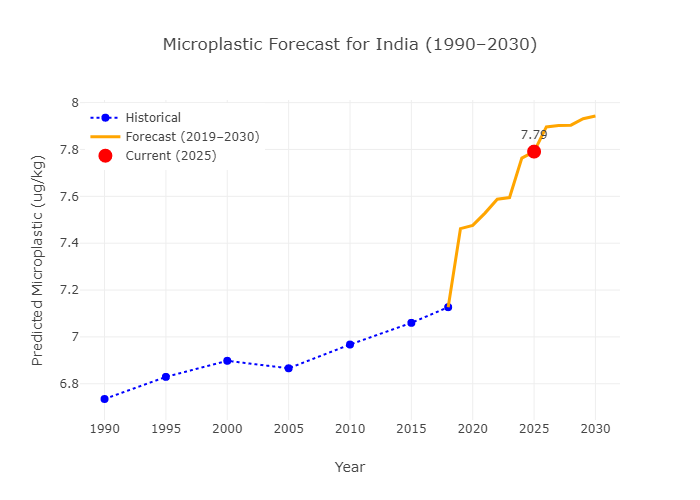

In [180]:
import plotly.graph_objects as go

# 9.7 Plotting the historical and forecasted data for the selected country
fig_forecast = go.Figure()

# Historical (dots and line)
fig_forecast.add_trace(go.Scatter(
    x=historical_years,
    y=historical_values,
    mode='markers+lines',
    name='Historical',
    marker=dict(color='blue', size=8),
    line=dict(dash='dot', color='blue')
))

# Forecast (solid line)
fig_forecast.add_trace(go.Scatter(
    x=forecast_years_with_2018,
    y=forecast_values_with_2018,
    mode='lines',
    name='Forecast (2019–2030)',
    line=dict(color='orange', width=3)
))

# Highlight current year i.e. 2025
fig_forecast.add_trace(go.Scatter(
    x=[highlight_year],
    y=[highlight_value],
    mode='markers+text',
    name='Current (2025)',
    marker=dict(color='red', size=14, symbol='circle'),
    text=[f"{highlight_value:.2f}"],
    textposition="top center",
    showlegend=True
))

fig_forecast.update_layout(
    title=f"Microplastic Forecast for {user_country} (1990–2030)",
    xaxis_title="Year",
    yaxis_title="Predicted Microplastic (ug/kg)",
    xaxis=dict(dtick=5, range=[1988, 2032]),
    legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01)
)
fig_forecast.show()

import plotly.io as pio

# Save as PNG
pio.write_image(fig_forecast, 'forecast_plot.png')

# Display in notebook as static image
from IPython.display import Image
Image('forecast_plot.png')

---

### **Interpretation:**

- The graph above shows the historical data mapped with the forecasted data done by the model which was trained on the features given in the historical data. As we can see the historical data ranges from the year 1990 up till the year 2018 after which the model forecasts the consumption rate from 2019 up till 2030.

- The graph also tell us the current year i.e. 2025 consumption rate which is fairly accurate based on the historical trends as well as it shows a forecast on how the consumption will continue to look like if the practices are not changed.

---

In [181]:
# 9.8 Percentage increase in microplastic consumption for the next five years
current_value_2025 = highlight_value
avg_2026_2030 = forecast_df[(forecast_df['year'] >= 2026) & (forecast_df['year'] <= 2030)]['Predicted Microplastic (ug/kg)'].mean()
percent_increase = ((avg_2026_2030 - current_value_2025) / current_value_2025) * 100

print(f"\nPredicted microplastic consumption in {user_country} for 2025: {current_value_2025:.2f} ug/kg")
print(f"Average predicted microplastic consumption in {user_country} for 2026–2030: {avg_2026_2030:.2f} ug/kg")
print(f"Potential percentage increase in the next five years: {percent_increase:.2f}%")


Predicted microplastic consumption in India for 2025: 7.79 ug/kg
Average predicted microplastic consumption in India for 2026–2030: 7.92 ug/kg
Potential percentage increase in the next five years: 1.60%


In [182]:
# 9.9 Feature Importance, their contribution to the model and visualization
# Feature importance for XGBoost
importances = xgboost_model.feature_importances_

# Create a DataFrame for feature importance
feature_importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': importances
})

In [183]:
# Function to sort and prettify feature names i.e. replace underscores with spaces and capitalize
def prettify_feature(name):
    return name.replace('_', ' ').title()
feature_importance_df['Pretty Feature'] = feature_importance_df['Feature'].apply(prettify_feature)

In [184]:
# Function to add weights to the feature importance as per user selection
feature_importance_df['Weighted Importance'] = [
    imp * 1.25 if feat in selected_categories else imp
    for feat, imp in zip(feature_importance_df['Feature'], feature_importance_df['Importance'])
]

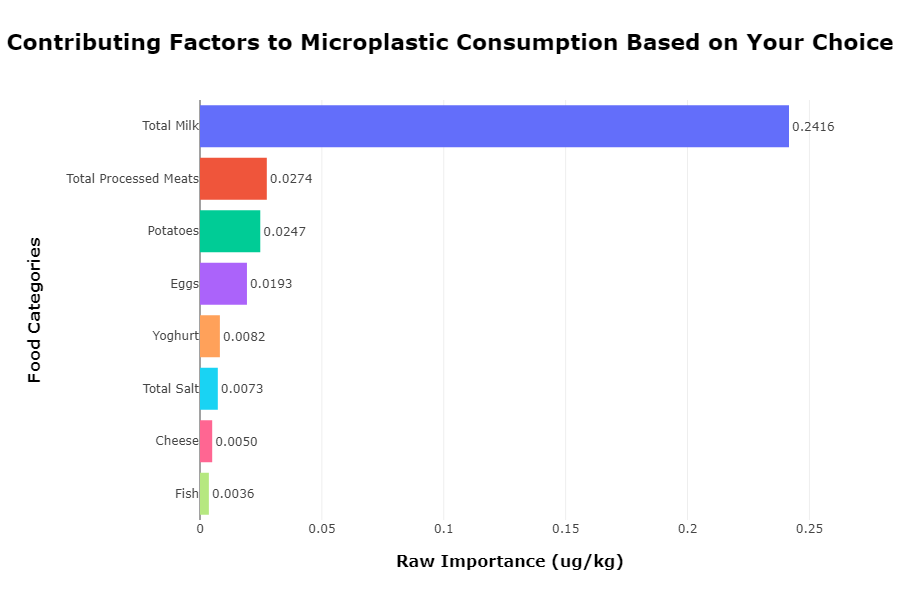

In [185]:
#9.10 Vizualization of Feature Importance based on user selection and Results

import plotly.express as px

# 9.10.1 Filter to only user-selected categories
df_selected = feature_importance_df[feature_importance_df['Feature'].isin(selected_categories)].copy()

# 9.10.2 Sort by importance (for best visual order)
df_selected = df_selected.sort_values('Importance', ascending=False)

# 9.10.3 Plotting the feature importance

fig_selected = px.bar(
    df_selected,
    x='Importance',
    y='Pretty Feature',
    orientation='h',
    text_auto='0.4f',
    color='Pretty Feature',
    color_discrete_sequence=px.colors.qualitative.Plotly,
    title='Contributing Factors to Microplastic Consumption Based on Your Choice',
    labels={'Pretty Feature': 'Food Category', 'Importance': 'Raw Importance (ug/kg)'}
)

fig_selected.update_traces(
    textposition='outside',  # This puts the label outside the bar
    cliponaxis=False         # Ensures labels are visible even if bar is at plot edge
)

fig_selected.update_layout(
    yaxis=dict(
        title=dict(
            text='<b>Food Categories</b>',
            font=dict(size=16, color='black')
        ),
        title_standoff=20,
        automargin=True
    ),
    xaxis=dict(
        title=dict(
            text='<b>Raw Importance (ug/kg)</b>',
            font=dict(size=16, color='black')
        ),
        title_standoff=20
    ),
    margin=dict(l=200),
    height=600,
    width=900,
    showlegend=False,
    title=dict(
        text='<b>Contributing Factors to Microplastic Consumption Based on Your Choice</b>',
        font=dict(size=22, color='black'),
        x=0.5,
        xanchor='center'
    )
)

# 9.10.4 Show the plot
fig_selected.show()

# Save as PNG
pio.write_image(fig_selected, 'selected_plot.png')

# Display in notebook as static image
from IPython.display import Image
Image('selected_plot.png')

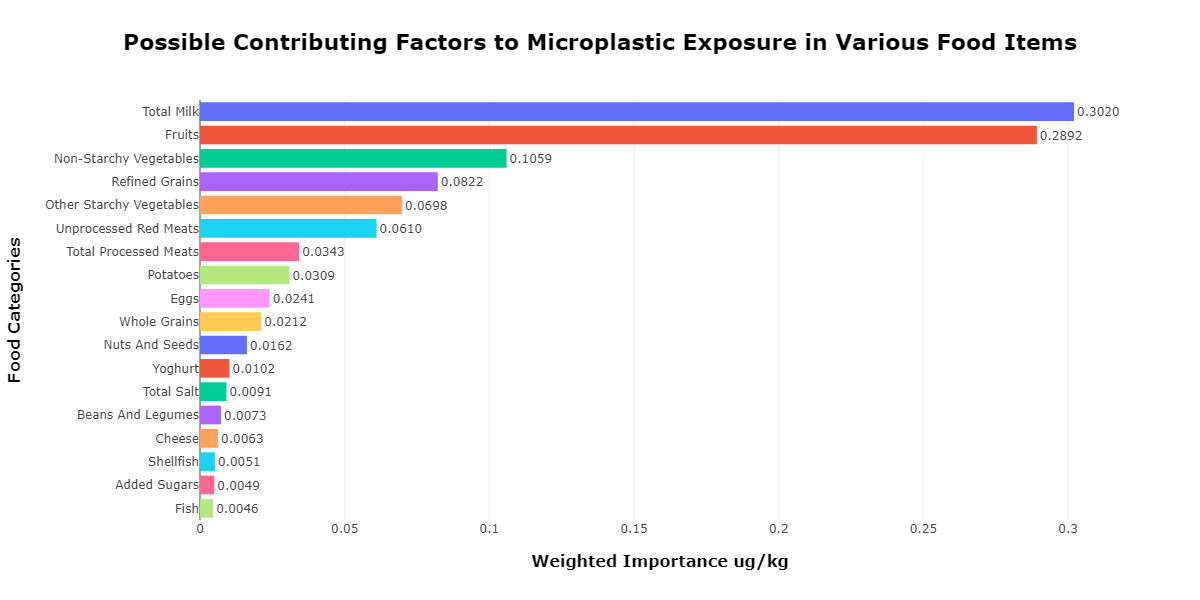

In [186]:
#9.10.5 Feature Importance based on all features for added visualization and insights
# Sort by weighted importance for better visualization
feature_importance_df = feature_importance_df.sort_values('Weighted Importance', ascending=False)

fig_importance = px.bar(
    feature_importance_df,
    x='Weighted Importance',
    y='Pretty Feature',
    orientation='h',
    text_auto='0.4f',
    color='Pretty Feature',
    color_discrete_sequence=px.colors.qualitative.Plotly,
    title='Possible Contributing Factors to Microplastic Exposure in Various Food Items',
    labels={
        'Pretty Feature': 'Food Category',
        'Weighted Importance': 'Weighted Importance ug/kg'
    }
)

fig_importance.update_traces(
    textposition='outside',
    cliponaxis=False
)

fig_importance.update_layout(
    yaxis=dict(
        title=dict(
            text='<b>Food Categories</b>',
            font=dict(size=16, color='black')
        ),
        title_standoff=20,
        automargin=True
    ),
    xaxis=dict(
        title=dict(
            text='<b>Weighted Importance ug/kg</b>',
            font=dict(size=16, color='black')
        ),
        title_standoff=20
    ),
    margin=dict(l=200),
    height=600,
    width=1200,
    showlegend=False,
    title=dict(
        text='<b>Possible Contributing Factors to Microplastic Exposure in Various Food Items</b>',
        font=dict(size=22, color='black'),
        x=0.5,
        xanchor='center'
    )
)

# 9.10.6 Show the plot
fig_importance.show()

# Save as PNG
pio.write_image(fig_importance, 'imp_plot.png')

# Display in notebook as static image
from IPython.display import Image
Image('imp_plot.png')

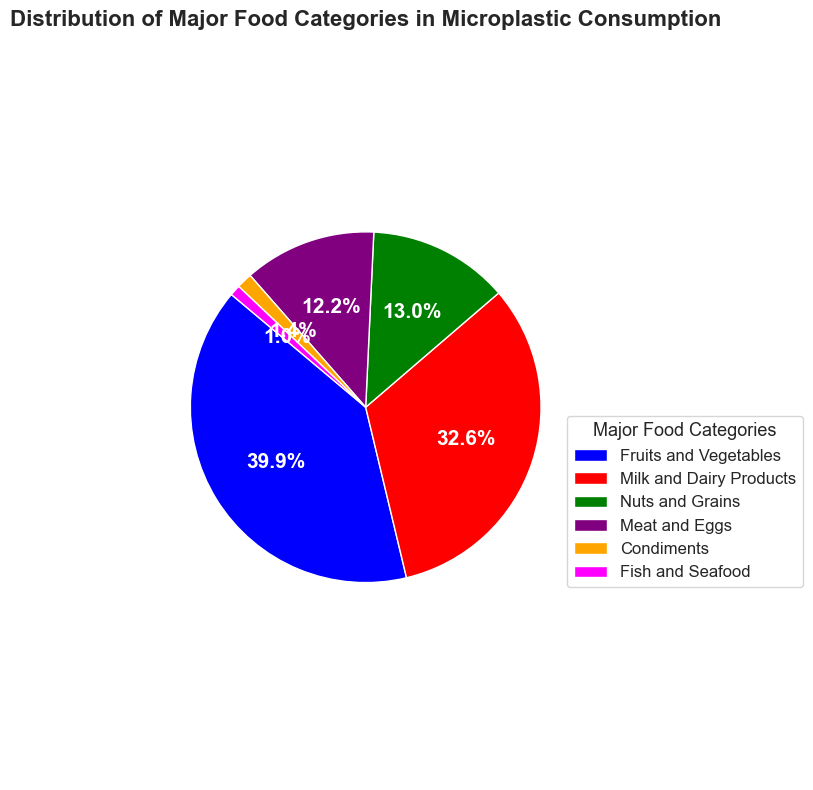

In [ ]:
import matplotlib.pyplot as plt

# Mapping from features to major categories
category_map = {
    'cheese': 'Milk and Dairy Products',
    'yoghurt': 'Milk and Dairy Products',
    'total_milk': 'Milk and Dairy Products',
    'fish': 'Fish and Seafood',
    'shellfish': 'Fish and Seafood',
    'total_processed_meats': 'Meat and Eggs',
    'unprocessed_red_meats': 'Meat and Eggs',
    'eggs': 'Meat and Eggs',
    'fruits': 'Fruits and Vegetables',
    'non_starchy_vegetables': 'Fruits and Vegetables',
    'potatoes': 'Fruits and Vegetables',
    'other_starchy_vegetables': 'Fruits and Vegetables',
    'refined_grains': 'Nuts and Grains',
    'whole_grains': 'Nuts and Grains',
    'nuts_and_seeds': 'Nuts and Grains',
    'beans_and_legumes': 'Nuts and Grains',
    'total_salt': 'Condiments',
    'added_sugars': 'Condiments'
}

# Map each feature to its category
feature_importance_df['Category'] = feature_importance_df['Feature'].map(category_map)

# Group by the new categories and sum the weighted importance
category_importance = feature_importance_df.groupby('Category')['Weighted Importance'].sum().reset_index()

# Sort for a nice pie
category_importance = category_importance.sort_values('Weighted Importance', ascending=False)

# Define colors for each category (as many as you have categories)
category_colors = ['blue', 'red', 'green', 'purple', 'orange', 'magenta']

# Plot the pie chart
plt.figure(figsize=(8, 8))
patches, texts, autotexts = plt.pie(
    category_importance['Weighted Importance'],
    labels=category_importance['Category'],
    colors=category_colors[:len(category_importance)],
    autopct='%1.1f%%',
    startangle=140,
    textprops={'color': 'white', 'weight': 'bold', 'fontsize': 13}
)

# Make the percentage labels inside the slices more readable
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_weight('bold')
    autotext.set_fontsize(15)

# Add a legend to show which color corresponds to which category
plt.legend(
    patches,
    category_importance['Category'],
    title="Major Food Categories",
    loc="upper left",
    bbox_to_anchor=(1, 0.5),
    fontsize=12,
    title_fontsize=13
)

plt.title('Distribution of Major Food Categories in Microplastic Consumption', fontsize=16, fontweight='bold')
plt.axis('equal')  # Equal aspect ratio ensures the pie is drawn as a circle.
plt.tight_layout()
plt.show()

In [188]:
# 9.11 Results and Regime Classification
# 9.11.1 Get the regime for the most recent available year for the selected country
latest_regime_row = df_log[df_log['country'] == user_country].sort_values('year').iloc[-1]
regime = latest_regime_row['regime']

In [189]:
# 9.11.2 Set color and label for display
regime_display = {
    'Low':    {'color': 'green',  'label': 'Low Microplastic Consumption'},
    'Medium': {'color': 'orange', 'label': 'Medium Microplastic Consumption'},
    'High':   {'color': 'red',    'label': 'High Microplastic Consumption'}
}
label_color = regime_display[regime]['color']
label = regime_display[regime]['label']

In [190]:
# 9.11.3 Alert if predicted value is close to regime boundary
regime_bounds = (df_log.groupby('regime')['total_ug_per_kg'].agg(['min', 'max']).sort_values('min').reset_index())

# Fix overlapping if any: set each lower bound just above the previous upper bound
adjusted_ranges = []

prev_max = None

for idx, row in regime_bounds.iterrows():
    regime = row['regime']
    min_val = row['min']
    max_val = row['max']
    
    # For all but the first regime, set min to previous max + small value to show discontinuity
    if prev_max is not None:
        min_val = round(prev_max + 0.01, 2)
    adjusted_ranges.append((regime, min_val, max_val))
    prev_max = max_val

In [191]:
# 9.11.4 Find the current regime's index
regime_idx = regime_bounds[regime_bounds['regime'] == regime].index[0]
alert_msg = ""
alert_margin = 0.5  # ug/kg - a Threshold value for alerting

if regime == 'Low':
    upper_bound = regime_bounds.iloc[regime_idx]['max']
    if abs(current_value_2025 - upper_bound) < alert_margin:
        alert_msg = "Approaching Medium Regime!"
elif regime == 'Medium':
    lower_bound = regime_bounds.iloc[regime_idx]['min']
    upper_bound = regime_bounds.iloc[regime_idx]['max']
    if abs(current_value_2025 - lower_bound) < alert_margin:
        alert_msg = "Close to Low Regime!"
    elif abs(current_value_2025 - upper_bound) < alert_margin:
        alert_msg = "Approaching High Regime!"
elif regime == 'High':
    lower_bound = regime_bounds.iloc[regime_idx]['min']
    if abs(current_value_2025 - lower_bound) < alert_margin:
        alert_msg = "Just crossed into High Regime!"

In [192]:
# For Flask or Django:
from IPython.display import display, HTML

# Build HTML table
table_html = """
<table style="border-collapse:collapse; width:60%; margin-bottom:16px;">
  <tr>
    <th style="padding:8px; border:1px solid #ccc; text-align:center;">Regime</th>
    <th style="padding:8px; border:1px solid #ccc; text-align:center;">Range (ug/kg)</th>
  </tr>
"""

for _, row in regime_bounds.iterrows():
    regime = row['regime']
    color = regime_display.get(regime, '#fff')
    min_val = round(row['min'], 2)
    max_val = round(row['max'], 2)
    table_html += f"""
    <tr style="background-color:{color};">
      <td style="padding:8px; border:1px solid #ccc; text-align:center; font-weight:bold;">{regime}</td>
      <td style="padding:8px; border:1px solid #ccc; text-align:center;">{min_val} – {max_val}</td>
    </tr>
    """

table_html += "</table>"

# Display the table
display(HTML(table_html))

Regime,Range (ug/kg)
Low,6.09 – 7.74
Medium,6.88 – 8.0
High,7.22 – 8.19


---

### **Interpretation and Decision taken:**

- **As we can clearly see, the overlap between the ranges in the original regime table is a direct result of cluster overlaps during the unsupervised classification process. Such overlaps can create confusion and ambiguity in regime assignment, making it difficult to clearly distinguish between "Low", "Medium", and "High" microplastic consumption categories for users.**

- **To address this and ensure clarity, we have opted to manually define the regime ranges using aggregate statistics. This approach guarantees that each regime is exclusive and continuous, with no overlaps, so that every microplastic consumption value can be unambiguously assigned to a single regime. This adjustment improves interpretability and ensures that users receive clear and accurate regime classifications.**

---

In [193]:
# Manually define the ranges and text colors for regimes
manual_ranges = [
    ('Low',    6.00, 7.05,   'green'),
    ('Medium', 7.06, 7.74,   'orange'),
    ('High',   7.75, 8.19,   'red')
]

# Build HTML table with only the regime text colored
table_html = """
<table style="border-collapse:collapse; width:60%; margin-bottom:16px;">
  <tr>
    <th style="padding:8px; border:1px solid #ccc; text-align:center;">Regime</th>
    <th style="padding:8px; border:1px solid #ccc; text-align:center;">Range (ug/kg)</th>
  </tr>
"""

for regime, min_val, max_val, text_color in manual_ranges:
    table_html += f"""
    <tr>
      <td style="padding:8px; border:1px solid #ccc; text-align:center; font-weight:bold; color:{text_color};">{regime}</td>
      <td style="padding:8px; border:1px solid #ccc; text-align:center;">{min_val:.2f} – {max_val:.2f}</td>
    </tr>
    """

table_html += "</table>"

display(HTML(table_html))

Regime,Range (ug/kg)
Low,6.00 – 7.05
Medium,7.06 – 7.74
High,7.75 – 8.19


In [194]:
# 9.11.5 For web: render as HTML (Streamlit, Flask, Django, etc.)

consumption_text = f"Calculated Microplastic Consumption in {user_country} for the year {highlight_year} is: <b>{current_value_2025:.2f} µg/kg</b>"

# For web: render as HTML (Streamlit, Flask, Django, etc.)
html = (
    f'<div style="margin-bottom:8px; font-size: 1.2em">{consumption_text}</div>'
    f'<span style="font-weight:bold; font-size:1.6em">This falls under the </span>'
    f'<span style="color:{label_color}; font-weight:bold; font-size:1.6em">{label}</span>'
    f'<span style="font-weight:bold; font-size:1.6em"> regime.</span>'
)
if alert_msg:
    html += f' <span style="color:white; font-weight:bold;">({alert_msg})</span>'

display(HTML(html))

# For CLI or logs:
print(f"The Current Microplastic Consumption in {user_country} for the year {highlight_year} is: {current_value_2025:.2f} µg/kg")
print(f"Regime: {label}")
if alert_msg:
    print(f"Alert: {alert_msg}")

The Current Microplastic Consumption in India for the year 2025 is: 7.79 µg/kg
Regime: Medium Microplastic Consumption


---

### **Interpretation and Conclusion**

- The model effectively predicts and forecasts the **Microplastic Consumption Rate** for any selected country, leveraging both historical data and user inputs. Through the interactive interface, users can specify their country and food consumption categories, enabling personalized and relevant predictions.

- The results are presented through a series of clear and informative visualizations:
    - **Forecast Graph:** A line graph displays the projected microplastic consumption up to 2030, helping users understand both past trends and future expectations for their country.
   
   - **Category-Specific Insights:** Additional graphs highlight the impact of user-selected food categories, as well as the most influential contributors to microplastic intake, offering actionable insights into dietary sources.
   
   - **Pie Chart Distribution:** A pie chart summarizes the proportional contribution of major food groups, making it easy to identify which categories are the largest sources of microplastic exposure.

- Finally, the model classifies the user’s current microplastic consumption into regimes (such as low, medium, or high exposure), providing a clear assessment of where they stand relative to potential health risks. This comprehensive approach not only informs users of their present situation but also empowers them to make more informed dietary choices to mitigate future exposure.

- Overall, this workflow demonstrates how advanced forecasting models and interactive data visualizations can translate complex environmental health data into accessible, actionable knowledge for individuals and policymakers alike.

---